# 행복주택 우선 입지 선정
## : 다목적 공간 최적화 모델을 중심으로

![title](https://github.com/victolee0/dacon/blob/master/%ED%94%BC%ED%94%BC%ED%8B%B0_%EC%A0%9C%EB%AA%A9.png?raw=true)

## 서론
### a. 주제 선정 배경

![피피티 제목](https://github.com/victolee0/dacon/blob/master/%ED%94%BC%ED%94%BC%ED%8B%B0_%EB%89%B4%EC%8A%A4.png?raw=true)

치솟는 집값으로 인해 2030 청년들은 주거에 대한 불안감과 위기감을 안고 살아갑니다.  

정부가 공급확대 등 다양한 부동산 대책을 내놓고 있지만, 불안은 사그라들지 않고 소위 "패닉바잉" 현상은 지속되고 있습니다.  

청년으로서 관심을 가질 수 밖에 없는 실생활에 밀접한 문제인 만큼, 본 분석에서는 **청년들의 주거문제를 해결하기 위한 정책**을 주제로 삼고자 합니다.  
![행복주택](https://github.com/victolee0/dacon/blob/master/%ED%94%BC%ED%94%BC%ED%8B%B0_%ED%96%89%EB%B3%B52.png?raw=true)
정부의 다양한 주거정책 중, 청년 세대를 직접적인 대상으로 하는 공공임대주택 정책인 행복주택을 중심으로 하여 어느 곳에 행복주택이 우선적으로 공급되어야 하는지를 분석해보고자 합니다.

하지만 본 분석은 단순한 입지 선정에 국한되지 않고 조금 더 나아가려고 합니다. 

[서울 뉴타운-재개발 해제지역 386곳중 절반이 방치...](https://www.donga.com/news/Economy/article/all/20210416/106438850/1)  

위 기사처럼, 뉴타운 해제구역의 방치로 인해 건물의 노후화와 지역 쇠퇴 등의 문제가 발생해 해제지역 주민들의 안전과 기본권이 위협을 받고 있습니다.  

만약 입지 선정의 후보지를 뉴타운 해제구역으로 하여 행복주택의 입지를 선정한다면, **청년 주거문제와 뉴타운 해제구역 방치 문제를 모두 해결**할 수 있는 방안을 제시할 수 있게 됩니다.  

하나의 정책으로 두 가지 문제를 동시에 해결할 수 있다면 금상첨화일 것입니다. 

따라서, 본 분석에서는 **청년 행복주택 우선 입지선정**을 주제로 청년 주거문제와 뉴타운 해제구역 방치 문제를 해결하고자 합니다.



### b.분석 흐름

![피피티](https://github.com/victolee0/dacon/blob/master/%ED%94%BC%ED%94%BC%ED%8B%B0_%ED%9D%90%EB%A6%842.png?raw=true)

### c. 사용 데이터

![데이터](https://github.com/victolee0/dacon/blob/master/%ED%94%BC%ED%94%BC%ED%8B%B0_%EB%8D%B0%EC%9D%B4%ED%84%B0.png?raw=true)

[국가통계포털](https://kosis.kr/publication/publicationThema.do)

국내 인구 이동 통계

청년 사회 / 경제 실태 조사

주택 이외의 거처 주거 실태 조사

### d. 대한민국 주거 실태

#### <전입·전출 지도>

In [145]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore') 

# 시각화 관련 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
sns.set_theme(style='white',palette='pastel')
import matplotlib.pyplot as plt
fontpath = 'C:/Windows/Fonts/gulim.ttc'
font_name = mpl.font_manager.FontProperties(fname=fontpath, size=10).get_name()
plt.rc('font', family=font_name)
import googlemaps
import plotly.express as px
import json
pd.options.plotting.backend = 'plotly'
import plotly.io as pio
pio.renderers.default = "notebook_connected"
import rpy2
# 입지 선정을 위한 최적화 관련 라이브러리
from pyscipopt import Model, quicksum, multidict
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

분석에 필요한 라이브러리를 불러옵니다.

In [152]:
# 이동 시간 계산 함수 정의
def with_bus(start, end, apikey):
    gmaps = googlemaps.Client(key=apikey)
    result = gmaps.directions(start, end, mode='transit')[0]['legs'][0]
    return result['distance'], result['duration']

In [147]:
area = ['서울', '부산', '대전', '대구', '인천', '광주', '울산', '세종', '경기', '강원', '충북', '충남', '전북', '전남', '경북', '경남', '제주']
new_area = ['서울특별시', '부산광역시','대전광역시', '대구광역시', '인천광역시', '광주광역시', '울산광역시', '세종특별자치시', '경기도', '강원도', '충청북도', '충청남도', '전라북도', '전라남도', '경상북도', '경상남도', '제주특별자치도']

data_2020 = pd.read_excel('data/2020년(연간)_03022213.xlsx')
data_2020 = data_2020[(data_2020['전출지'] == '전국') & data_2020['전입지'].isin(area)].iloc[:,:3]
data_2020 = data_2020.replace(area, new_area)
geojson = json.load(open('data/korea.geo.json', encoding='utf-8'))

In [148]:
fig = px.choropleth_mapbox(data_2020,geojson=geojson,locations='전입지',color='계',
                           color_continuous_scale="Viridis",
                           mapbox_style="carto-positron",
                           zoom=5, center = {"lat": 37, "lon": 127},
                           featureidkey='properties.CTP_KOR_NM',
                           labels={'계':'순이동자수'})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

위 지도는 **지역 별 인구 유출, 유입**을 순이동자수라는 지표를 통해 나타낸 것으로, **순이동자 수**는 **전입 인구 - 전출 인구**를 의미합니다.  

순이동자수 값이 클수록 인구 유입이 많고, 작을수록 인구 유출이 많음을 의미합니다. 

지도상의 색이 **어두울수록 인구의 유출이 많고 밝을수록 인구 유입이 많도록** 나타냈습니다.

경기도에서만 전입이 더 많고, 경기도를 제외한 서울과 비수도권 지역에서는 전출이 더 많습니다.

전국의 많은 인구가 **수도권**, 특히 경기도에 쏠리고 있음을 확인할 수 있습니다. 

특히 가장 많은 전출이 발생한 지역으로는 서울이 나타났는데, 왜 이런 현상이 나타난 것인지 서울의 집값 데이터를 살펴보겠습니다.

#### <매매가격지수>
: 기준시점 대비 현재시점의 매매가격비를 기준시점이 100인 수치로 환산한 값

In [2]:
%load_ext rpy2.ipython

C:\Users\victolee\anaconda3\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [18]:
%%R
#시각화를 위한 라이브러리 불러오기
library(tidyverse)
library(plyr)
library(dplyr)
library(data.table)
library(ggplot2)
library(gridExtra)

size_sales_index <- fread('data/규모별_매매가격지수 (17년 1월 ~ 20년 12월).csv')
size_month_index <- fread('data/규모별_월세가격지수 (17년 1월 ~ 20년 12월).csv')
size_lease_index <- fread('data/규모별_전세가격지수 (17년 1월 ~ 20년 12월).csv')

# 부산 row 삭제
size_sales_index <- size_sales_index[!(size_sales_index$'지역별(1)' == "부산" ), ]
size_month_index <- size_month_index[!(size_month_index$'지역별(1)' == "부산" ), ]
size_lease_index <- size_lease_index[!(size_lease_index$'지역별(1)' == "부산" ), ]


# 도심권 아파트 규모별 
data <- size_sales_index[(size_sales_index$'지역별(3)' == "도심권" & size_sales_index$'주택유형별(1)' == "아파트" ), ]

# line graph
data <- t(data)
data[6:53, ] <- as.numeric(data[6:53, ])
colnames(data) <- NULL
rownames(data) <- NULL

colnames(data) <- c(paste0('규모', seq(1:6)))

data <- data[6:53, ]

month <- seq(as.Date('2017/01/01', '%Y/%m/%d'), as.Date('2020/12/31', '%Y/%m/%d'), 'month')
month <- format(as.Date(month), "%Y-%m")

data <- t(data)

colnames(data) <- month

data <- melt(id=1,data)

colnames(data) <- c('규모별', '날짜', '매매가격지수')

data[,3] <- as.numeric(data[,3])

cen <- ggplot(data, aes(x = 날짜, y = 매매가격지수,
                 ,group = 규모별, color=규모별)) + geom_line(size=1.2, aes(color=규모별))+
  theme(panel.background = element_rect(color='black', linetype='solid'),
        axis.title.x=element_text(face="bold", size=15), 
        axis.title.y=element_text(face="bold", size=15),
        plot.title=element_text(hjust = 0.5, face="bold", size=20),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size=7, face="bold", colour = "grey50"),
        strip.background = element_rect(fill="white", color="black"),
        strip.text = element_text(face="bold"))+
        theme(legend.position = 'none')+
  labs(title = '도심권 아파트\n규모별 매매가격지수', x="조사연월", y="매매가격지수", color="규모별")

# bar graph (가격변동률)
data[ ,4] <- c(100)

data[,5] <- data[ ,3] - data[ ,4]

colnames(data) <- c('규모별', '날짜', '매매가격지수','기준값','가격변동률')

cen2 <- ggplot(data, aes(x = 날짜, y = 가격변동률,
                 ,group = 규모별, color = 규모별)) + geom_bar(aes(fill=규모별,color=규모별), alpha=0.5, stat='identity')+
  facet_wrap(~규모별, ncol=3)+
  theme(panel.background = element_rect(color='black', linetype='solid'),
        axis.title.x=element_text(face="bold", size=15), 
        axis.title.y=element_text(face="bold", size=15),
        plot.title=element_text(hjust = 0.5, face="bold", size=20),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size=7, face="bold", colour = "grey50"),
        strip.background = element_rect(fill="white", color="black"),
        strip.text = element_text(face="bold"))+
        theme(legend.position = 'none')+
  labs(title = '도심권 아파트\n규모별 매매가격변동률', x="조사연월", y="가격변동률", color="규모별")

# 동북권
data <- size_sales_index[(size_sales_index$'지역별(3)' == "동북권" & size_sales_index$'주택유형별(1)' == "아파트" ), ]

# line graph
data <- t(data)
data[6:53, ] <- as.numeric(data[6:53, ])
colnames(data) <- NULL
rownames(data) <- NULL

colnames(data) <- c(paste0('규모', seq(1:6)))

data <- data[6:53, ]

month <- seq(as.Date('2017/01/01', '%Y/%m/%d'), as.Date('2020/12/31', '%Y/%m/%d'), 'month')
month <- format(as.Date(month), "%Y-%m")

data <- t(data)

colnames(data) <- month

data <- melt(id=1,data)

colnames(data) <- c('규모별', '날짜', '매매가격지수')

data[,3] <- as.numeric(data[,3])

noreas <- ggplot(data, aes(x = 날짜, y = 매매가격지수,
                        ,group = 규모별, color=규모별)) + geom_line(size=1.2, aes(color=규모별))+
  theme(panel.background = element_rect(color='black', linetype='solid'),
        axis.title.x=element_text(face="bold", size=15), 
        axis.title.y=element_text(face="bold", size=15),
        plot.title=element_text(hjust = 0.5, face="bold", size=20),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size=7, face="bold", colour = "grey50"),
        strip.background = element_rect(fill="white", color="black"),
        strip.text = element_text(face="bold"))+
        theme(legend.position = 'none')+
  labs(title = '동북권 아파트\n규모별 매매가격지수', x="조사연월", y="매매가격지수", color="규모별")

# bar graph (가격변동률)
data[ ,4] <- c(100)

data[,5] <- data[ ,3] - data[ ,4]

colnames(data) <- c('규모별', '날짜', '매매가격지수','기준값','가격변동률')

noreas2 <- ggplot(data, aes(x = 날짜, y = 가격변동률,
                         ,group = 규모별, color = 규모별)) + geom_bar(aes(fill=규모별,color=규모별), alpha=0.5, stat='identity')+
  facet_wrap(~규모별, ncol=3)+
  theme(panel.background = element_rect(color='black', linetype='solid'),
        axis.title.x=element_text(face="bold", size=15), 
        axis.title.y=element_text(face="bold", size=15),
        plot.title=element_text(hjust = 0.5, face="bold", size=20),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size=7, face="bold", colour = "grey50"),
        strip.background = element_rect(fill="white", color="black"),
        strip.text = element_text(face="bold"))+
        theme(legend.position = 'none')+
  labs(title = '동북권 아파트\n규모별 매매가격변동률', x="조사연월", y="가격변동률", color="규모별")


# 서북권
data <- size_sales_index[(size_sales_index$'지역별(3)' == "서북권" & size_sales_index$'주택유형별(1)' == "아파트" ), ]

# line graph
data <- t(data)
data[6:53, ] <- as.numeric(data[6:53, ])
colnames(data) <- NULL
rownames(data) <- NULL

colnames(data) <- c(paste0('규모', seq(1:6)))

data <- data[6:53, ]

month <- seq(as.Date('2017/01/01', '%Y/%m/%d'), as.Date('2020/12/31', '%Y/%m/%d'), 'month')
month <- format(as.Date(month), "%Y-%m")

data <- t(data)

colnames(data) <- month

data <- melt(id=1,data)

colnames(data) <- c('규모별', '날짜', '매매가격지수')

data[,3] <- as.numeric(data[,3])

norwes <- ggplot(data, aes(x = 날짜, y = 매매가격지수,
                           ,group = 규모별, color=규모별)) + geom_line(size=1.2, aes(color=규모별))+
  theme(panel.background = element_rect(color='black', linetype='solid'),
        axis.title.x=element_text(face="bold", size=15), 
        axis.title.y=element_text(face="bold", size=15),
        plot.title=element_text(hjust = 0.5, face="bold", size=20),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size=7, face="bold", colour = "grey50"),
        strip.background = element_rect(fill="white", color="black"),
        strip.text = element_text(face="bold"))+
        theme(legend.position = 'none')+
  labs(title = '서북권 아파트\n규모별 매매가격지수', x="조사연월", y="매매가격지수", color="규모별")

# bar graph (가격변동률)
data[ ,4] <- c(100)

data[,5] <- data[ ,3] - data[ ,4]

colnames(data) <- c('규모별', '날짜', '매매가격지수','기준값','가격변동률')

norwes2 <- ggplot(data, aes(x = 날짜, y = 가격변동률,
                         ,group = 규모별, color = 규모별)) + geom_bar(aes(fill=규모별,color=규모별), alpha=0.5, stat='identity')+
  facet_wrap(~규모별, ncol=3)+
  theme(panel.background = element_rect(color='black', linetype='solid'),
        axis.title.x=element_text(face="bold", size=15), 
        axis.title.y=element_text(face="bold", size=15),
        plot.title=element_text(hjust = 0.5, face="bold", size=20),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size=7, face="bold", colour = "grey50"),
        strip.background = element_rect(fill="white", color="black"),
        strip.text = element_text(face="bold"))+
        theme(legend.position = 'none')+
  labs(title = '서북권 아파트\n규모별 매매가격변동률', x="조사연월", y="가격변동률", color="규모별")


# 서남권
data <- size_sales_index[(size_sales_index$'지역별(3)' == "서남권" & size_sales_index$'주택유형별(1)' == "아파트" ), ]

# line graph
data <- t(data)
data[6:53, ] <- as.numeric(data[6:53, ])
colnames(data) <- NULL
rownames(data) <- NULL

colnames(data) <- c(paste0('규모', seq(1:6)))

data <- data[6:53, ]

month <- seq(as.Date('2017/01/01', '%Y/%m/%d'), as.Date('2020/12/31', '%Y/%m/%d'), 'month')
month <- format(as.Date(month), "%Y-%m")

data <- t(data)

colnames(data) <- month

data <- melt(id=1,data)

colnames(data) <- c('규모별', '날짜', '매매가격지수')

data[,3] <- as.numeric(data[,3])

souwes <- ggplot(data, aes(x = 날짜, y = 매매가격지수,
                           ,group = 규모별, color=규모별)) + geom_line(size=1.2, aes(color=규모별))+
  theme(panel.background = element_rect(color='black', linetype='solid'),
        axis.title.x=element_text(face="bold", size=15), 
        axis.title.y=element_text(face="bold", size=15),
        plot.title=element_text(hjust = 0.5, face="bold", size=20),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size=7, face="bold", colour = "grey50"),
        strip.background = element_rect(fill="white", color="black"),
        strip.text = element_text(face="bold"))+
        theme(legend.position = 'none')+
  labs(title = '서남권 아파트\n규모별 매매가격지수', x="조사연월", y="매매가격지수", color="규모별")

# bar graph (가격변동률)
data[ ,4] <- c(100)

data[,5] <- data[ ,3] - data[ ,4]

colnames(data) <- c('규모별', '날짜', '매매가격지수','기준값','가격변동률')

souwes2 <- ggplot(data, aes(x = 날짜, y = 가격변동률,
                         ,group = 규모별, color = 규모별)) + geom_bar(aes(fill=규모별,color=규모별), alpha=0.5, stat='identity')+
  facet_wrap(~규모별, ncol=3)+
  theme(panel.background = element_rect(color='black', linetype='solid'),
        axis.title.x=element_text(face="bold", size=15), 
        axis.title.y=element_text(face="bold", size=15),
        plot.title=element_text(hjust = 0.5, face="bold", size=20),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size=7, face="bold", colour = "grey50"),
        strip.background = element_rect(fill="white", color="black"),
        strip.text = element_text(face="bold"))+
        theme(legend.position = 'none')+
  labs(title = '서남권 아파트\n규모별 매매가격변동률', x="조사연월", y="가격변동률", color="규모별")


# 동남권
data <- size_sales_index[(size_sales_index$'지역별(3)' == "동남권" & size_sales_index$'주택유형별(1)' == "아파트" ), ]

# line graph
data <- t(data)
data[6:53, ] <- as.numeric(data[6:53, ])
colnames(data) <- NULL
rownames(data) <- NULL

colnames(data) <- c(paste0('규모', seq(1:6)))

data <- data[6:53, ]

month <- seq(as.Date('2017/01/01', '%Y/%m/%d'), as.Date('2020/12/31', '%Y/%m/%d'), 'month')
month <- format(as.Date(month), "%Y-%m")

data <- t(data)

colnames(data) <- month

data <- melt(id=1,data)

colnames(data) <- c('규모별', '날짜', '매매가격지수')

data[,3] <- as.numeric(data[,3])

soueas <- ggplot(data, aes(x = 날짜, y = 매매가격지수,
                           ,group = 규모별, color=규모별)) + geom_line(size=1.2, aes(color=규모별))+
  theme(panel.background = element_rect(color='black', linetype='solid'),
        axis.title.x=element_text(face="bold", size=15), 
        axis.title.y=element_text(face="bold", size=15),
        plot.title=element_text(hjust = 0.5, face="bold", size=20),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size=7, face="bold", colour = "grey50"),
        strip.background = element_rect(fill="white", color="black"),
        strip.text = element_text(face="bold"))+
  labs(title = '동남권 아파트\n규모별 매매가격지수', x="조사연월", y="매매가격지수", color="규모별")

# bar graph (가격변동률)
data[ ,4] <- c(100)

data[,5] <- data[ ,3] - data[ ,4]

colnames(data) <- c('규모별', '날짜', '매매가격지수','기준값','가격변동률')

soueas2 <- ggplot(data, aes(x = 날짜, y = 가격변동률,
                         ,group = 규모별, color = 규모별)) + geom_bar(aes(fill=규모별,color=규모별), alpha=0.5, stat='identity')+
  facet_wrap(~규모별, ncol=3)+
  theme(panel.background = element_rect(color='black', linetype='solid'),
        axis.title.x=element_text(face="bold", size=15), 
        axis.title.y=element_text(face="bold", size=15),
        plot.title=element_text(hjust = 0.5, face="bold", size=20),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size=7, face="bold", colour = "grey50"),
        strip.background = element_rect(fill="white", color="black"),
        strip.text = element_text(face="bold"))+
        theme(legend.position = 'none')+
  labs(title = '동남권 아파트\n규모별 매매가격변동률', x="조사연월", y="가격변동률", color="규모별");

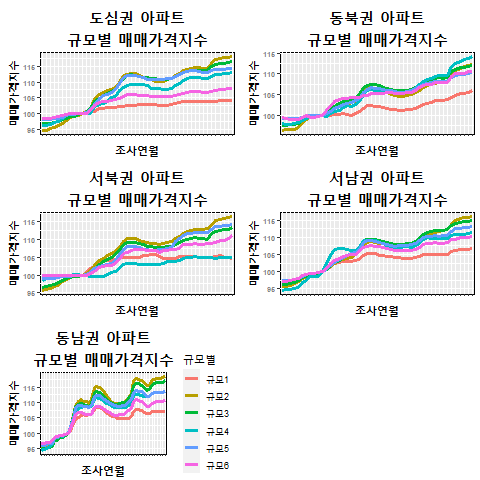

In [7]:
%%R

grid.arrange(cen, noreas, norwes, souwes, soueas, nrow=3)

*조사연월: 2017년 1월 ~ 2020년 12월*

기준시점은 2017년 10월로, 모든 권역에서 
**2019년 하반기에 큰 폭**으로 
아파트 매매가격이 **상승**했음을 알 수 있습니다. 

2018년 8월부터 2019년 1월까진
가장 큰 폭으로 하락한 추세를 보였습니다.

#### <매매가격변동률>
: 기준시점을 100으로 보았을 때, 현 시점의 매매가격이 얼만큼 증감했는지 나타낸 비율

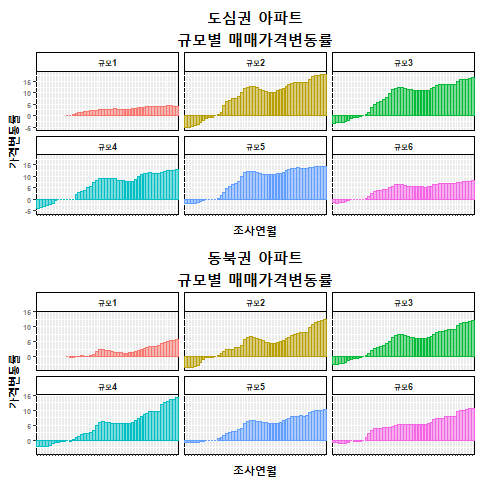

In [23]:
%%R

grid.arrange(cen2, noreas2, nrow=2)

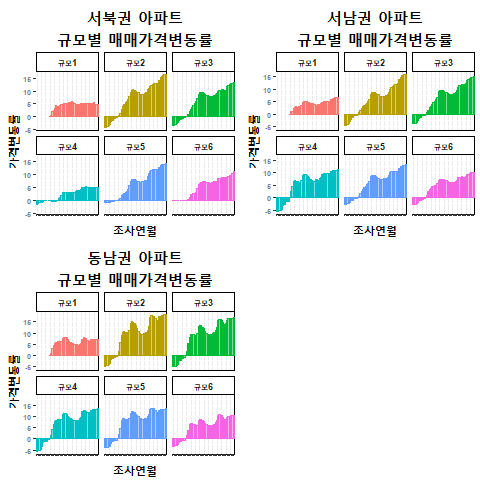

In [24]:
%%R 

grid.arrange(norwes2, souwes2, soueas2, nrow=2)

*조사연월: 2017년 1월 ~ 2020년 12월*

bar의 수치가15를 기록한다면,
2017년 10월보다 15만큼 상승했다고 해석할 수 있습니다.

모든 권역에서 대체적으로 규모2의 매매가격
변동 폭이 크게 나타났습니다. 
반면에, 규모1과 6은 변동이 적었습니다.

#### <수급동향>
: 수요와 공급의 비중을 점수화한 수치

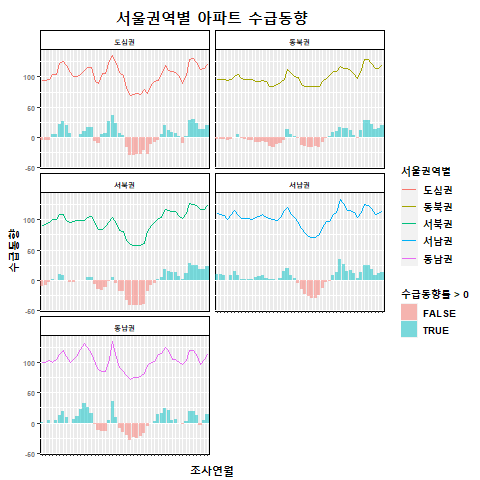

In [9]:
%%R

library(tidyverse)
library(plyr)
library(dplyr)
library(data.table)
library(ggplot2)

sales_supdem <- fread('data/주요지역별_매매수급동향 (17년 1월 ~ 20년 12월).csv')
month_supdem <- fread('data/주요지역별_월세수급동향 (17년 1월 ~ 20년 12월).csv')
lease_supdem <- fread('data/주요지역별_전세수급동향 (17년 1월 ~ 20년 12월).csv')

sales_supdem <- sales_supdem[!(sales_supdem$'지역별(1)' == "부산" ), ]
month_supdem <- month_supdem[!(month_supdem$'지역별(1)' == "부산" ), ]
lease_supdem <- lease_supdem[!(lease_supdem$'지역별(1)' == "부산" ), ]

# 서울권역별 수급동향
data <- sales_supdem[(sales_supdem$'지역별(1)' == "서울" & sales_supdem$'주택유형별(1)' == "아파트" ), ]

data <- data[!(data$'지역별(2)' == '소계'), ]
data <- data[!(data$'지역별(3)' == '소계'), ]

# 데이터셋 완성
data <- t(data)
data[5:52, ] <- as.numeric(data[5:52, ])

colnames(data) <- NULL
rownames(data) <- NULL

colnames(data) <- c('도심권', '동북권','서북권','서남권','동남권')

data <- data[5:52, ]

month <- seq(as.Date('2017/01/01', '%Y/%m/%d'), as.Date('2020/12/31', '%Y/%m/%d'), 'month')
month <- format(as.Date(month), "%Y-%m")

data <- t(data)

colnames(data) <- month

data <- melt(id=1,data)

colnames(data) <- c('서울권역별', '날짜', '수급동향')

data[,3] <- as.numeric(data[,3])

# bar graph
data[ ,4] <- c(100)

data[,5] <- data[ ,3] - data[ ,4]

colnames(data) <- c('서울권역별', '날짜', '수급동향','기준값','수급동향률')

ggplot(data, aes(x = 날짜, group = 서울권역별, fill = 수급동향률 > 0)) + geom_bar(aes(y= 수급동향률), alpha=0.5, stat='identity')+
  facet_wrap(~서울권역별, ncol=2) + geom_line(aes(y=수급동향, color=서울권역별))+
  theme(panel.background = element_rect(color='black', linetype='solid'),
        axis.title.x=element_text(face="bold", size=15), 
        axis.title.y=element_text(face="bold", size=15),
        plot.title=element_text(hjust = 0.5, face="bold", size=20),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size=7, face="bold", colour = "grey50"),
        legend.title=element_text(face="bold", size=10),
        legend.text = element_text(face="bold", size=10),
        strip.background = element_rect(fill="white", color="black"),
        strip.text = element_text(face="bold"))+
  labs(title = '서울권역별 아파트 수급동향', x="조사연월",y="수급동향", color="서울권역별")

- 0에 가까울수록 공급우위 
- 200에 가까울수록 수요우위 
- 100에 가까울수록 수요와 공급이 비슷함

*조사연월: 2017년 1월 ~ 2020년 12월*

bar plot은 (100 – 수급동향) 수치를 나타낸 것으로, 
수급동향률 > 0이 **TRUE**임은
수요 우위를 나타냅니다. 

2019년 하반기를 기준으로 대부분의 권역에서 
**수요가 우위인 현상**이 나타나고 있습니다. 
이는 아파트 매매를 원하는 사람은 많으나,
그만큼 공급이 원활히 이루어지고 있지 않음을 의미합니다.

#### <평당 거래금액 추이>
: 1평당 실거래가 금액

In [10]:
from plotnine import *
from matplotlib import gridspec

In [11]:
#데이터 불러오기 및 전처리 함수 정의
def trade(file_name):
    data = pd.read_excel(file_name, skiprows=15,header=1,thousands=',',dtype={'계약년월': 'str'})
    data = data.assign(평당금액 = data['거래금액(만원)'] / data['전용면적(㎡)'] * 3.3)
    data = data.assign(구 = data['시군구'].str.split().str[1])
    data = data.assign(연도 = data['계약년월'].str[0:4])
    data = data[['구','평당금액','연도']]
    return data

In [12]:
#데이터 불러오기
apt2017 = trade('data/아파트(매매)__실거래가_2017.xlsx')
apt2018 = trade('data/아파트(매매)__실거래가_2018.xlsx')
apt2019 = trade('data/아파트(매매)__실거래가_2019.xlsx')
apt2020 = trade('data/아파트(매매)__실거래가_2020.xlsx')
apt = pd.concat([apt2017,apt2018,apt2019,apt2020])

dandok2017 = trade('data/단독다가구(매매)_실거래가_2017.xlsx')
dandok2018 = trade('data/단독다가구(매매)_실거래가_2018.xlsx')
dandok2019 = trade('data/단독다가구(매매)_실거래가_2019.xlsx')
dandok2020 = trade('data/단독다가구(매매)_실거래가_2020.xlsx')
dandok = pd.concat([dandok2017,dandok2018,dandok2019,dandok2020])

office2017 = trade('data/오피스텔(매매)__실거래가_2017.xlsx')
office2018 = trade('data/오피스텔(매매)__실거래가_2018.xlsx')
office2019 = trade('data/오피스텔(매매)__실거래가_2019.xlsx')
office2020 = trade('data/오피스텔(매매)__실거래가_2020.xlsx')
office = pd.concat([office2017,office2018,office2019,office2020])

yeonlib2017 = trade('data/연립다세대(매매)__실거래가_2017.xlsx')
yeonlib2018 = trade('data/연립다세대(매매)__실거래가_2018.xlsx')
yeonlib2019 = trade('data/연립다세대(매매)__실거래가_2019.xlsx')
yeonlib2020 = trade('data/연립다세대(매매)__실거래가_2020.xlsx')
yeonlib = pd.concat([yeonlib2017,yeonlib2018,yeonlib2019,yeonlib2020])


In [13]:
#연도별, 구별로 Groupby
grouped_apt = apt['평당금액'].groupby([apt['연도'],apt['구']])
grouped_dandok = dandok['평당금액'].groupby([dandok['연도'],dandok['구']])
grouped_office = office['평당금액'].groupby([office['연도'],office['구']])
grouped_yeonlib = yeonlib['평당금액'].groupby([yeonlib['연도'],yeonlib['구']])

#구별 아파트 거래금액 확인
grouped_apt2017 = apt2017.groupby(['구'])
grouped_apt2018 = apt2018.groupby(['구'])
grouped_apt2019 = apt2019.groupby(['구'])
grouped_apt2020 = apt2020.groupby(['구'])

In [14]:
# 연도별, 구별 평균 평당금액
price_mean_apt = pd.DataFrame(grouped_apt.mean()).reset_index()
price_mean_dandok = pd.DataFrame(grouped_dandok.mean()).reset_index()
price_mean_office = pd.DataFrame(grouped_office.mean()).reset_index()
price_mean_yeonlib = pd.DataFrame(grouped_yeonlib.mean()).reset_index()

#구별 아파트 평균 평당금액 & 중앙값
price_mean_apt2017 = grouped_apt2017['평당금액'].agg(['mean','median']).reset_index()
price_mean_apt2018 = grouped_apt2018['평당금액'].agg(['mean','median']).reset_index()
price_mean_apt2019 = grouped_apt2019['평당금액'].agg(['mean','median']).reset_index()
price_mean_apt2020 = grouped_apt2020['평당금액'].agg(['mean','median']).reset_index()

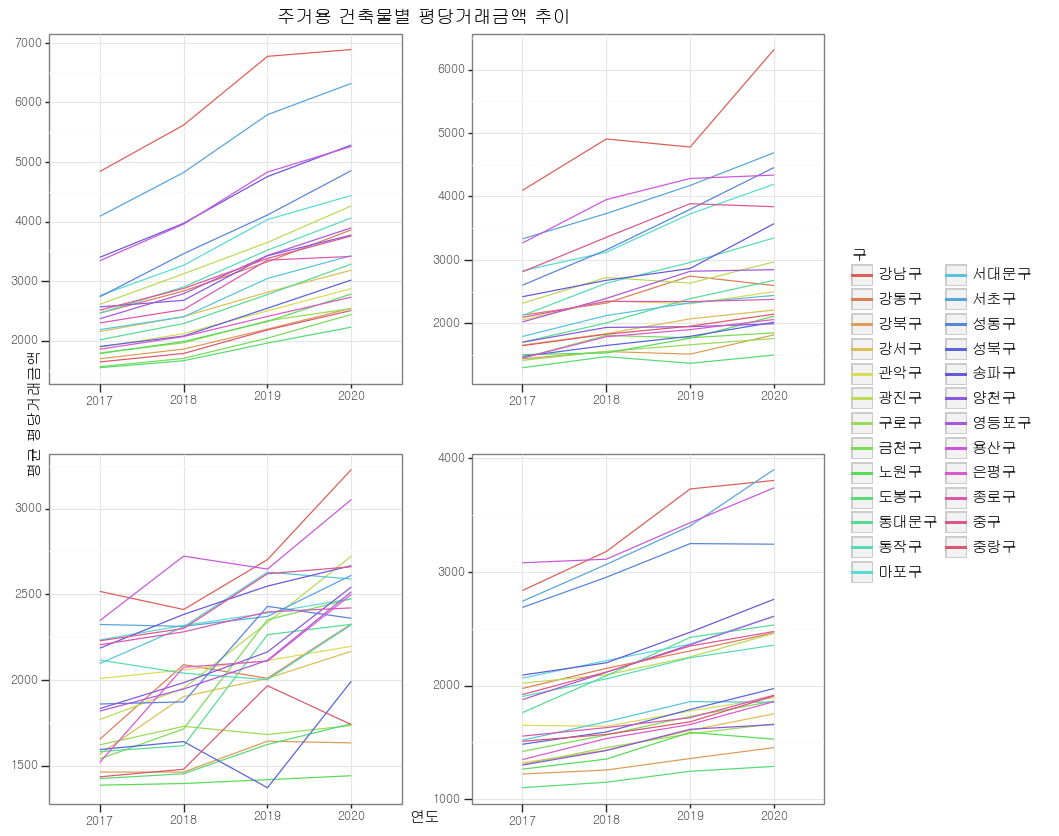

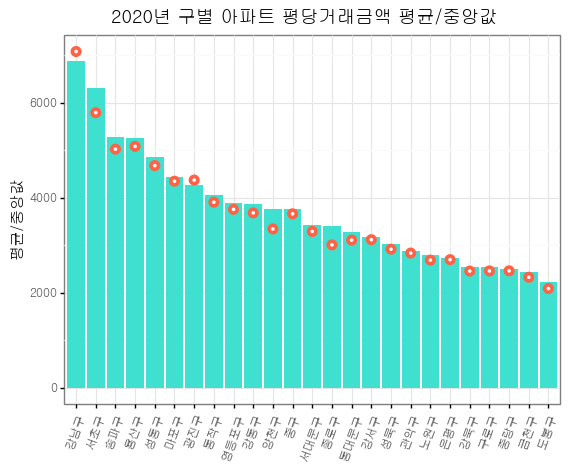

<ggplot: (177772384266)>

In [15]:
#연도별 주거용 건축물 평균 거래금액 추이
p1 = (ggplot(price_mean_apt,aes(x='연도',y='평당금액',color='구',group='구')) + geom_line() + theme_bw() + labs(y="평균 거래금액 (단위:만원)")) +theme(text=element_text(fontproperties=font_name))
p2 = (ggplot(price_mean_dandok,aes(x='연도',y='평당금액',color='구',group='구')) + geom_line() + theme_bw()  + labs(y="평균 거래금액 (단위:만원)")) + theme(text=element_text(fontproperties=font_name))
p3 = (ggplot(price_mean_office,aes(x='연도',y='평당금액',color='구',group='구')) + geom_line() + theme_bw()  +labs(y="평균 거래금액 (단위:만원)")) + theme(text=element_text(fontproperties=font_name))
p4 = (ggplot(price_mean_yeonlib,aes(x='연도',y='평당금액',color='구',group='구')) + geom_line() + theme_bw()  +labs(y="평균 거래금액 (단위:만원)")) + theme(text=element_text(fontproperties=font_name))

fig = (ggplot()+geom_blank(data=apt)  +theme_void()+ labs(title = '주거용 건축물별 평당거래금액 추이',x='연도',y='평균 평당거래금액')  + theme(figure_size=(10, 10))).draw()

# Create gridspec for adding subpanels to the blank figure
gs = gridspec.GridSpec(2,2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])

# Add subplots to the figure
_ = p1._draw_using_figure(fig, [ax1])
_ = p2._draw_using_figure(fig, [ax2])
_ = p3._draw_using_figure(fig, [ax3])
_ = p4._draw_using_figure(fig, [ax4])

fig.show()

#2020년 구별 아파트 평균 평당금액 & 중앙값 
(ggplot(price_mean_apt2020) + geom_bar((aes(x='reorder(구,-mean)',y='mean')),stat='identity',fill='turquoise')+ geom_point(aes(x='구',y='median'),stroke=1.5,color='tomato',fill='white')+ theme_bw() + theme(text=element_text(fontproperties=font_name),axis_text_x = element_text(angle = 70, hjust = 0.5, vjust = 1 )) + labs(title = '2020년 구별 아파트 평당거래금액 평균/중앙값',x='',y='평균/중앙값'))

*조사연월: 2017년 1월 ~ 2020년 12월*

- 첫번째 그래프는 왼쪽 위부터 시계방향으로 **아파트, 단독다가구, 연립다세대, 오피스텔**의 평당거래금액의 추이를 나타낸 그래프입니다.  
오피스텔을 제외한 서울의 모든 주거용 건축물이 거의 모든 구에서 **꾸준히 상승**하는 추세를 갖고 있는 것을 확인할 수 있습니다.  
또한, 모든 주거용 건축물에서 **강남구**의 거래금액이 **가장 높게** 자리잡고 있습니다.


*조사연월: 2020년 1 ~ 12월*
  
- 두번째 그래프는 2020년 서울시 구별로 아파트의 평당거래금액의 평균과 중앙값을 나타낸 그래프입니다. 막대그래프는 평균을, 점은 중앙값을 의미합니다.  
  **강남3구의 가격**이 가장 높았고, 용산구가 그 뒤를 이었습니다. 대다수의 구에서 거래금액 평균이 중앙값보다 높다는 점에서, **아파트 값이 비싼 쪽에 치우쳐 있음**을 확인할 수 있습니다.  
  
 
 
*대한민국 주거 현황*
- 따라서 인구 유입 시각화와 서울시 집값 데이터를 함께 살펴볼 때, **현재 서울의 치솟는 집값으로 인해 서울시에 많은 인구 전출이 발생하고 있음을 알 수 있습니다.**

## 본론 1
### a. 청년 세대 주거 현황
#### <청년 세대의 주거 인식>

In [2]:
# 설문조사 data를 불러와 바로 사용할 수 있도록 처리
def read_csv(file_name):
    data = pd.read_csv(file_name, encoding='cp949')
    data = data.rename(columns=data.iloc[1])
    return data

def my_autopct(pct):
    return (f'{pct:.2f}%') if pct > 8 else ''

#연령별로 두 개의 pie plot 그릴 때 사용
def draw_two_pie(data, x1, x2, y, title):
    fig, ax = plt.subplots(1,2, figsize=(15,10))
    ax[0].pie(data.iloc[x1,y:], autopct=my_autopct, textprops=dict(color='black', size='large'))
    ax[0].set_title(data.iloc[x1,1])
    ax[1].pie(data.iloc[x2,y:], autopct=my_autopct, textprops=dict(color='black', size='large'))
    ax[1].set_title(data.iloc[x2,1])
    ax[1].legend(data.iloc[0,y:], loc='lower right', bbox_to_anchor=(1.5,0.5))
    fig.suptitle(title, fontsize=16)
    return fig, ax

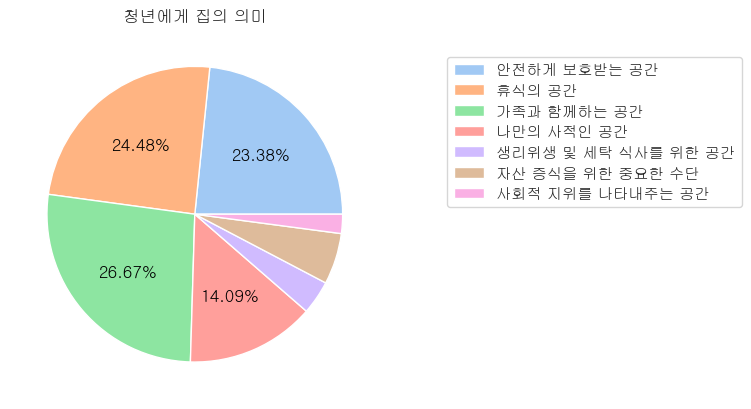

In [16]:
house_mean=read_csv("data/survey/집의_의미_20210722165329.csv")
plt.pie(house_mean.iloc[1,2:9],autopct=my_autopct, textprops=dict(color='black'))
plt.title("청년에게 집의 의미")
plt.legend(house_mean.iloc[0,2:9], loc='lower right', bbox_to_anchor=(2,0.5))
plt.show()

청년 세대에게 있어 집은 **가족과 함께하고, 안전하게 보호받고, 휴식을 취하는 공간**입니다.

즉, 이들에게 집이란 편안한 마음으로 휴식을 취하며 고된 일상에서 지친 몸과 마음을 달랠 수 있는 안정되고 행복한 삶을 영위하기 위한 가장 중요한 수단입니다.

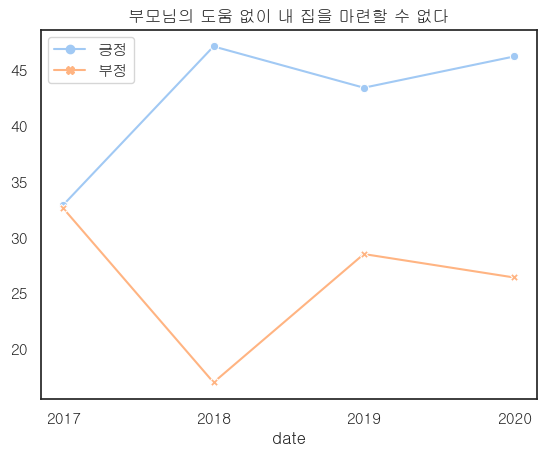

In [17]:
house_think = read_csv("data/survey/집에_대한_생각_20210722165141.csv")
house_think = house_think.transpose()
house_think = house_think.iloc[2:,:3]
house_think = house_think.rename(columns={0:'질문',1:'응답',2:'소계'})

date = [2017,2018,2019,2020]
op = ['그렇지 않다','그렇다','매우 그렇다']
h= house_think[(house_think['질문']=='부모님 도움 없이 내가 원하는 집을 마련하는 것은 불가능하다') & (house_think['응답']=='전혀 그렇지 않다') ]
h = h.assign(date=date)

for i in op:
    h1 = house_think[(house_think['질문']=='부모님 도움 없이 내가 원하는 집을 마련하는 것은 불가능하다') & (house_think['응답']==i) ]
    h1 = h1.assign(date=date)
    h = pd.merge(h, h1,left_on='date', right_on='date')
    
h.index=h['date']
h =h.drop(['응답_x','응답_y','질문_x','질문_y','date'],axis=1)
h.columns = ['전혀 그렇지 않다','그렇지 않다','그렇다','매우 그렇다']
h=h.astype('float')
h=h.assign(긍정 =h['그렇다']+h['매우 그렇다'],부정= h['그렇지 않다']+h['전혀 그렇지 않다'] )
h =h.drop(['전혀 그렇지 않다','그렇지 않다','그렇다','매우 그렇다'],axis=1)

sns.lineplot(data=h,markers=True, dashes=False)
plt.title("부모님의 도움 없이 내 집을 마련할 수 없다")
plt.xticks([2017, 2018, 2019,2020])
plt.show()

전세가 폭등으로 촉발된 주거 불안정성의 영향으로,
청년들에게 있어 ‘내 집 마련’은 더욱 어려운 현황입니다.
이에 청년들은 부모님의 **금전적 지원 없이는 
내 집을 마련하기 힘들다**고 인식하고 있습니다. 

아래에서 살펴 보겠지만 집값이 크게 상승함에 따라 나타나는 인식이라 미루어 볼 수 있겠습니다.

#### <청년 세대의 주거 비용>

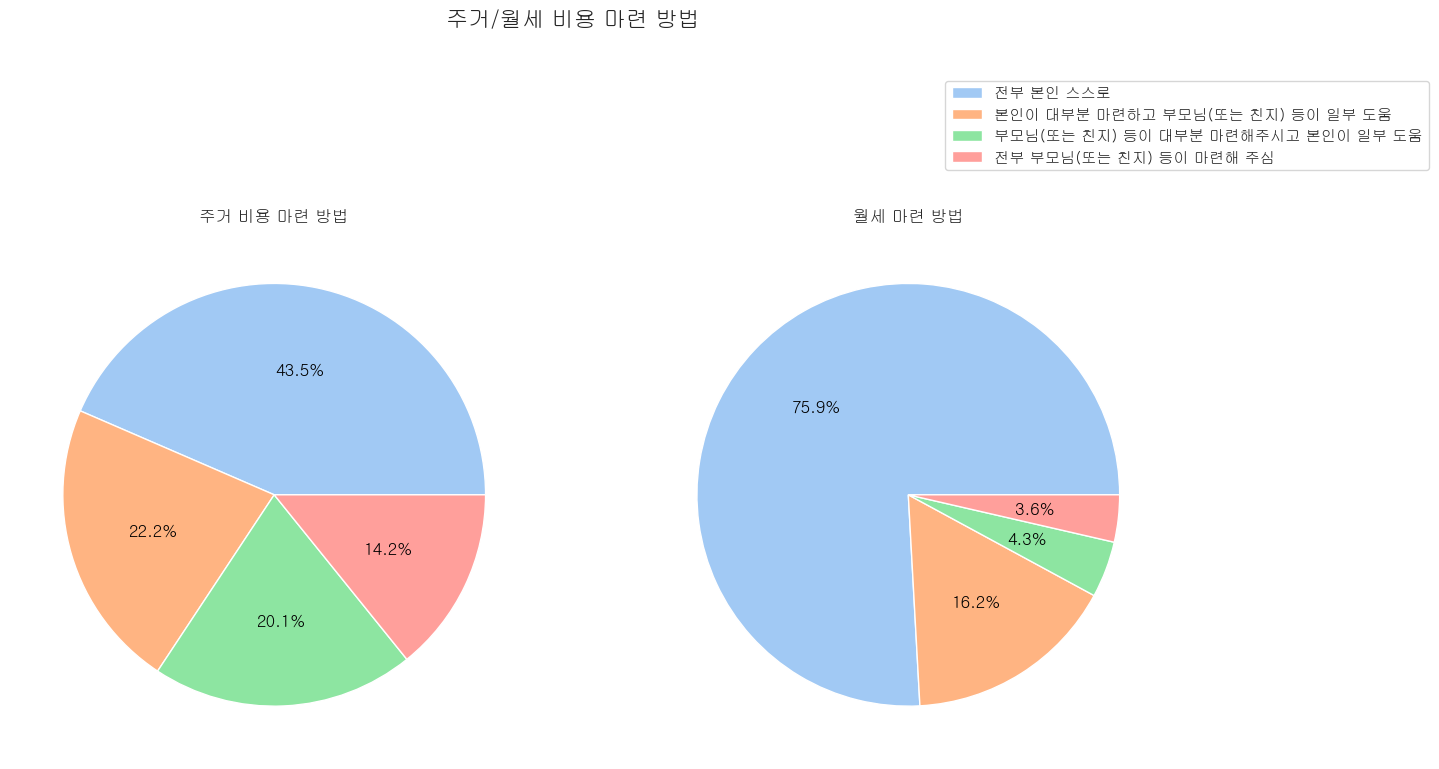

In [18]:
house_money = read_csv("data/survey/주거_비용_및_월세_마련_방법_20210722165312.csv")
fig, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].pie(house_money.iloc[2,2:6], autopct='%1.1f%%', textprops=dict(color='black'))
ax[0].set_title(house_money.iloc[0,2])
ax[1].pie(house_money.iloc[2,6:10], autopct='%1.1f%%', textprops=dict(color='black'))
ax[1].set_title(house_money.iloc[0,6])
ax[1].legend(house_money.iloc[1,2:6], loc='lower right', bbox_to_anchor=(1.5,1.1))
fig.suptitle("주거/월세 비용 마련 방법", fontsize=16)
plt.show()

청년들이 부모님에게 의존적이기 때문에 이런 현상이 발생하는 것은 아닙니다.

대다수의 청년들은 **주거비용을 스스로 부담**하고 있습니다. 특히 월세의 경우는 스스로 마련하는 것이 대부분입니다.

청년들은 이렇게 주거 문제를 스스로 해결하기 위해 노력하고 있는데, 이는 청년들이 점점 상승하는 집값을 따라잡기 어렵게 하기 때문에 **청년 세대의 주거 부담은 점점 커지게 될 것** 입니다.

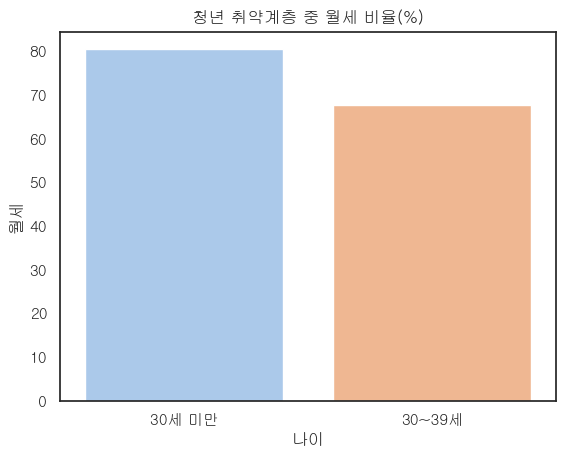

In [19]:
house_type = read_csv("data/survey/현재_거처의_점유_형태_20210725100717.csv")
house_type = house_type.rename(columns=house_type.iloc[1])
house_type=house_type.iloc[25:27,2:].astype('float')
house_type=house_type.assign(월세 =house_type['보증금 있는 월세']+house_type['보증금 없는 월세']+house_type['사글세·연세·일세·주세'])
house_type=house_type.assign(나이=['30세 미만','30~39세'])
sns.barplot(data= house_type,x='나이',y="월세")
plt.title("청년 취약계층 중 월세 비율(%)")
plt.show()

2-30대 청년의 70% 가량이 세들어 살고 있기 때문에 매달 지출되는 주거 비용은 '내 집 마련'을 더욱 어렵게 할 것입니다.

###  b. 주거 취약 계층 현황
#### <주거취약계층의 주거 비용 부담>

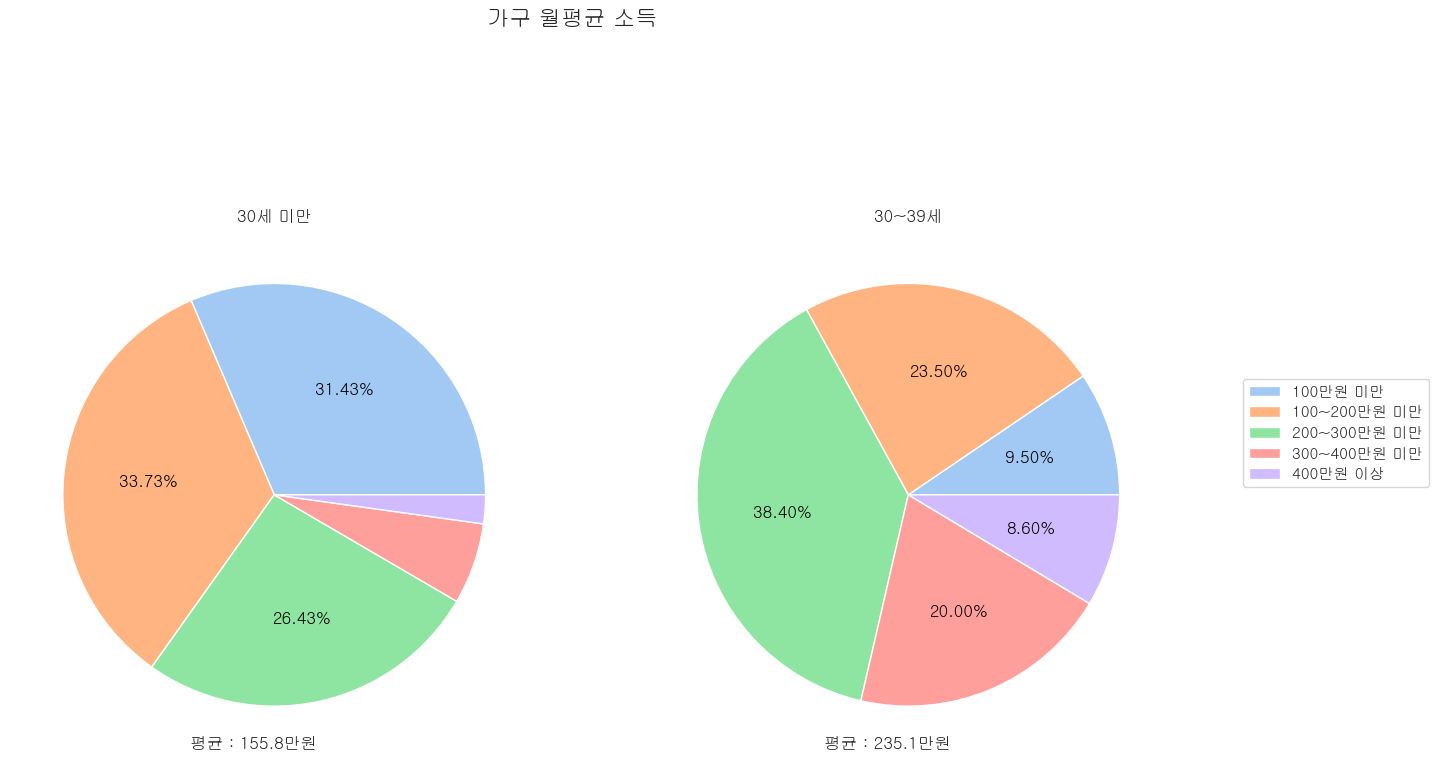

In [20]:
income = read_csv("data/survey/가구_월평균_소득_20210722165655.csv")
fig, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].pie(income.iloc[19,4:], autopct=my_autopct, textprops=dict(color='black'))
ax[0].set_title(income.iloc[19,1])
ax[0].text(x=-0.4,y=-1.2,s="평균 : "+income.iloc[19,3]+"만원")
ax[1].pie(income.iloc[20,4:], autopct=my_autopct, textprops=dict(color='black'))
ax[1].set_title(income.iloc[20,1])
ax[1].legend(income.iloc[0,4:], loc='lower right', bbox_to_anchor=(1.5,0.5))
ax[1].text(x=-0.4,y=-1.2,s="평균 : "+income.iloc[20,3]+"만원")
fig.suptitle("가구 월평균 소득", fontsize=16)
plt.show()

30세 미만의 경우, 월평균 소득인 155.8만원 중 
월세 34.9만원을 지출하고 있어 **소득의 22%를 
월세로 납부**하고 있습니다. 

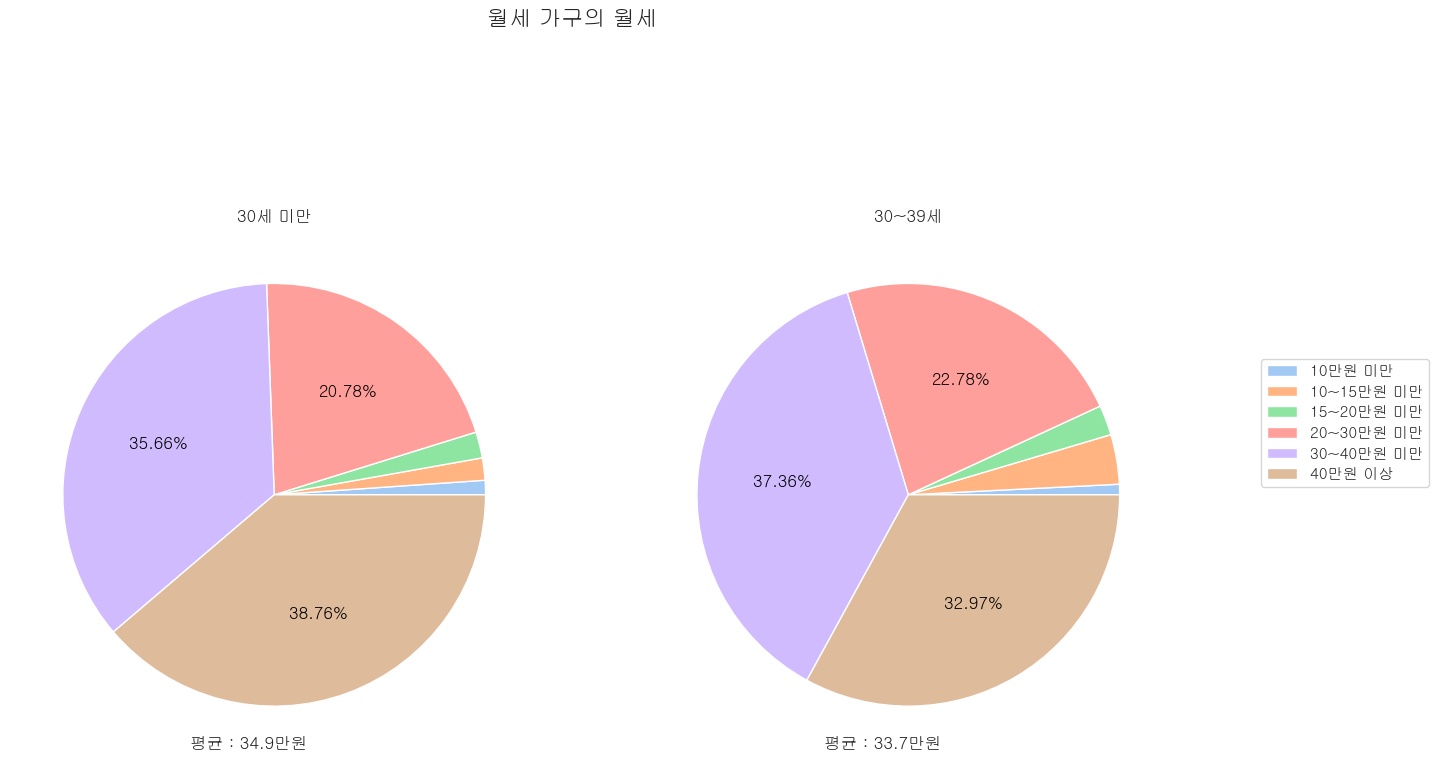

In [21]:
month_money = read_csv("data/survey/월세_가구의_월세_20210722165520.csv")
fig, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].pie(month_money.iloc[20,4:], autopct=my_autopct, textprops=dict(color='black'))
ax[0].set_title(month_money.iloc[20,1])
ax[0].text(x=-0.4,y=-1.2,s="평균 : "+month_money.iloc[20,3]+"만원")
ax[1].pie(month_money.iloc[21,4:], autopct=my_autopct, textprops=dict(color='black'))
ax[1].set_title(month_money.iloc[21,1])
ax[1].legend(month_money.iloc[0,4:], loc='lower right', bbox_to_anchor=(1.5,0.5))
ax[1].text(x=-0.4,y=-1.2,s="평균 : "+month_money.iloc[21,3]+"만원")
fig.suptitle("월세 가구의 월세", fontsize=16)
plt.show()

30~39세의 경우 월 평균 소득인 235.1만원 중 월세로 33.7만원을 지출하고 있어 **소득의 14%를 월세로 납부**하고 있습니다.

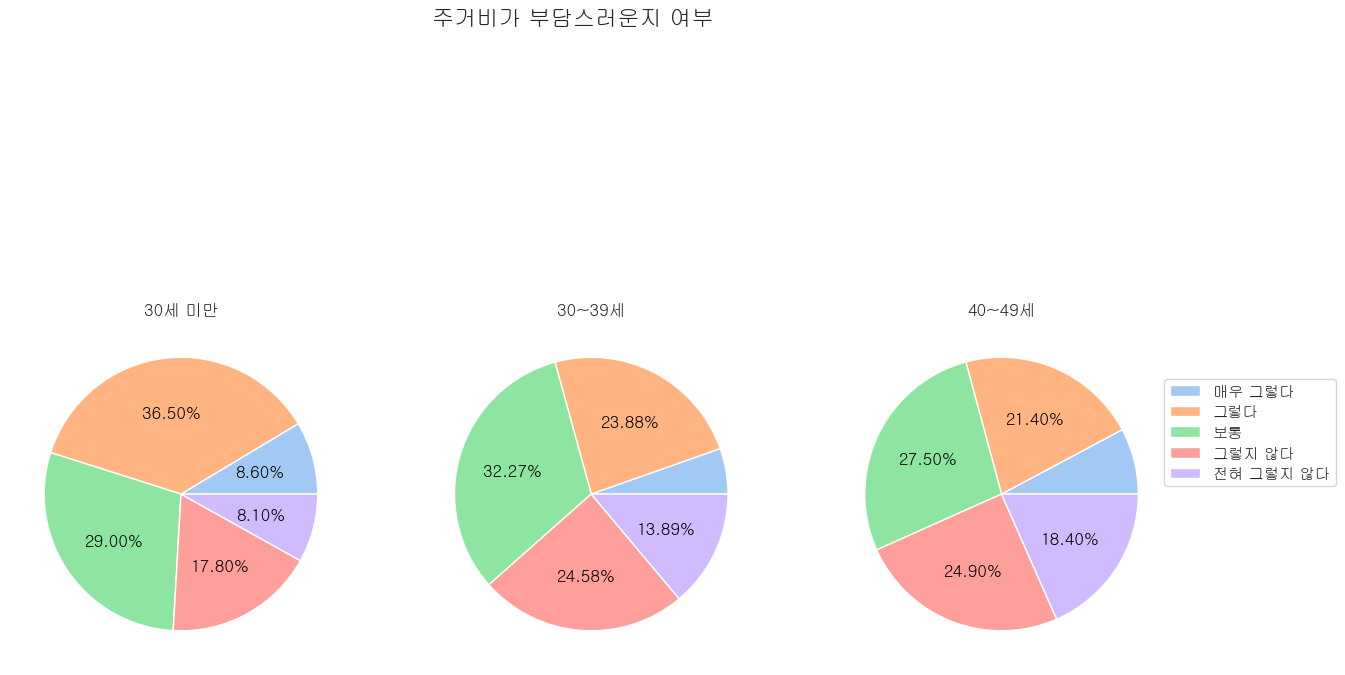

In [22]:
burden = read_csv("data/survey/지난_1년_간_주거비가_부담스러운_정도_20210722170020.csv")
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].pie(burden.iloc[24,3:], autopct=my_autopct, textprops=dict(color='black'))
ax[0].set_title(burden.iloc[24,1])
ax[1].pie(burden.iloc[25,3:], autopct=my_autopct, textprops=dict(color='black'))
ax[1].set_title(burden.iloc[25,1])
ax[2].pie(burden.iloc[26,3:], autopct=my_autopct, textprops=dict(color='black'))
ax[2].set_title(burden.iloc[26,1])
ax[2].legend(burden.iloc[0,3:], loc='lower right', bbox_to_anchor=(1.5,0.5))
fig.suptitle("주거비가 부담스러운지 여부", fontsize=16)
plt.show()

**30세 미만**의 경우, 대부분 세를 들어 살고 있는 청년들이 많을 것으로 
예측되어 **주거비가 부담스러운 정도가 다른 세대보다 많은 것**으로 나타납니다. 
30 ~ 39세·40 ~ 49세의 경우, 이전 세대보다 부담 정도가 낮게 나타나지만 ‘그렇다’와 ‘보통‘으로 응답한 비율이 꽤 높습니다.

위에서 살펴본 것 처럼 많은 청년들이 **소득이 적음에도 스스로 월세를 부담**하기 때문에 이런 결과가 나온 것으로 파악할 수 있습니다.


#### <주거취약계층의 주거지 조건>

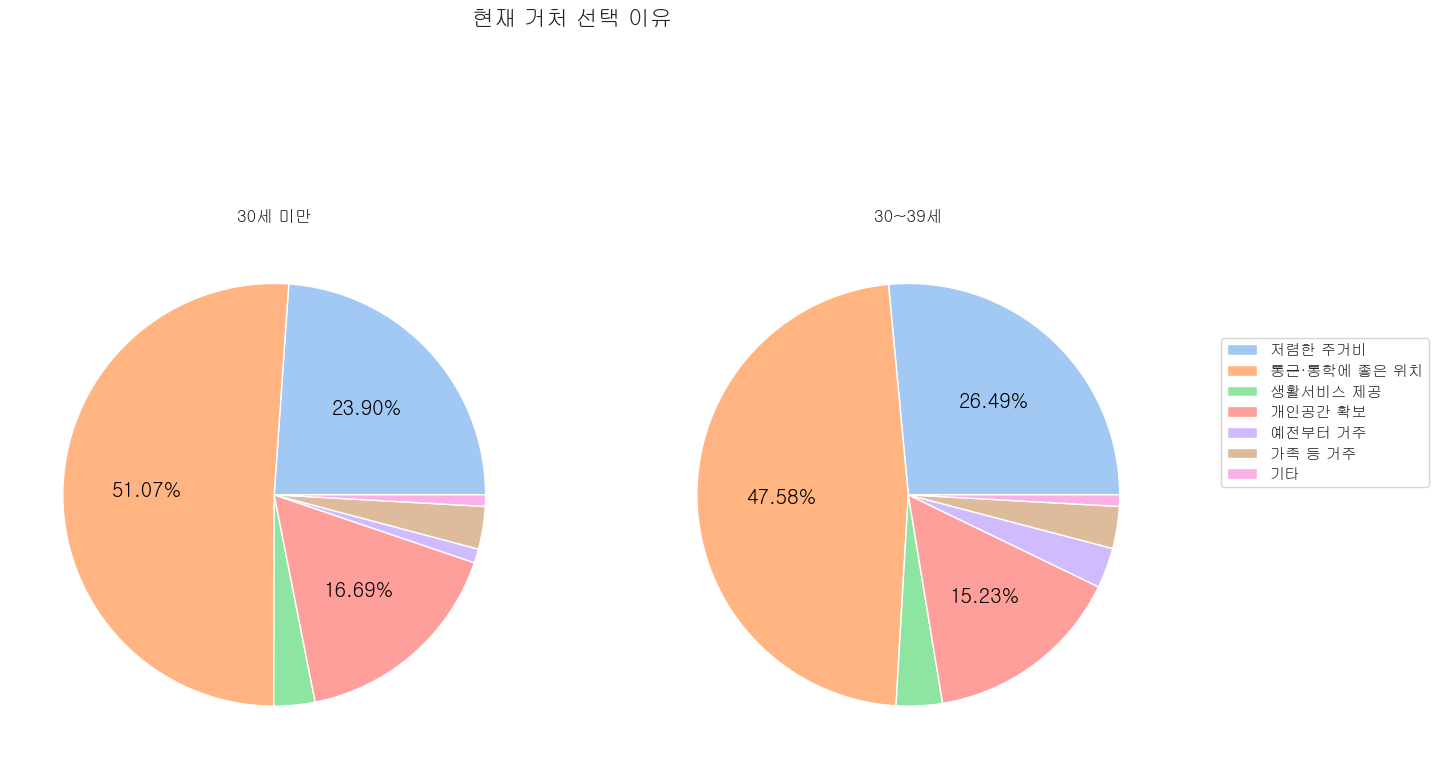

In [23]:
why_now_house = read_csv('data/survey/현재_거처_선택_이유_20210722165620.csv')
fig, ax = draw_two_pie(why_now_house, 24, 25, 3, "현재 거처 선택 이유")
fig

통근·통학이 잦은 청년 세대의 경우, 
통근·통학이 편리하고 좋은 위치에 거주하는 경우가
4~50%를 차지하고 있습니다.

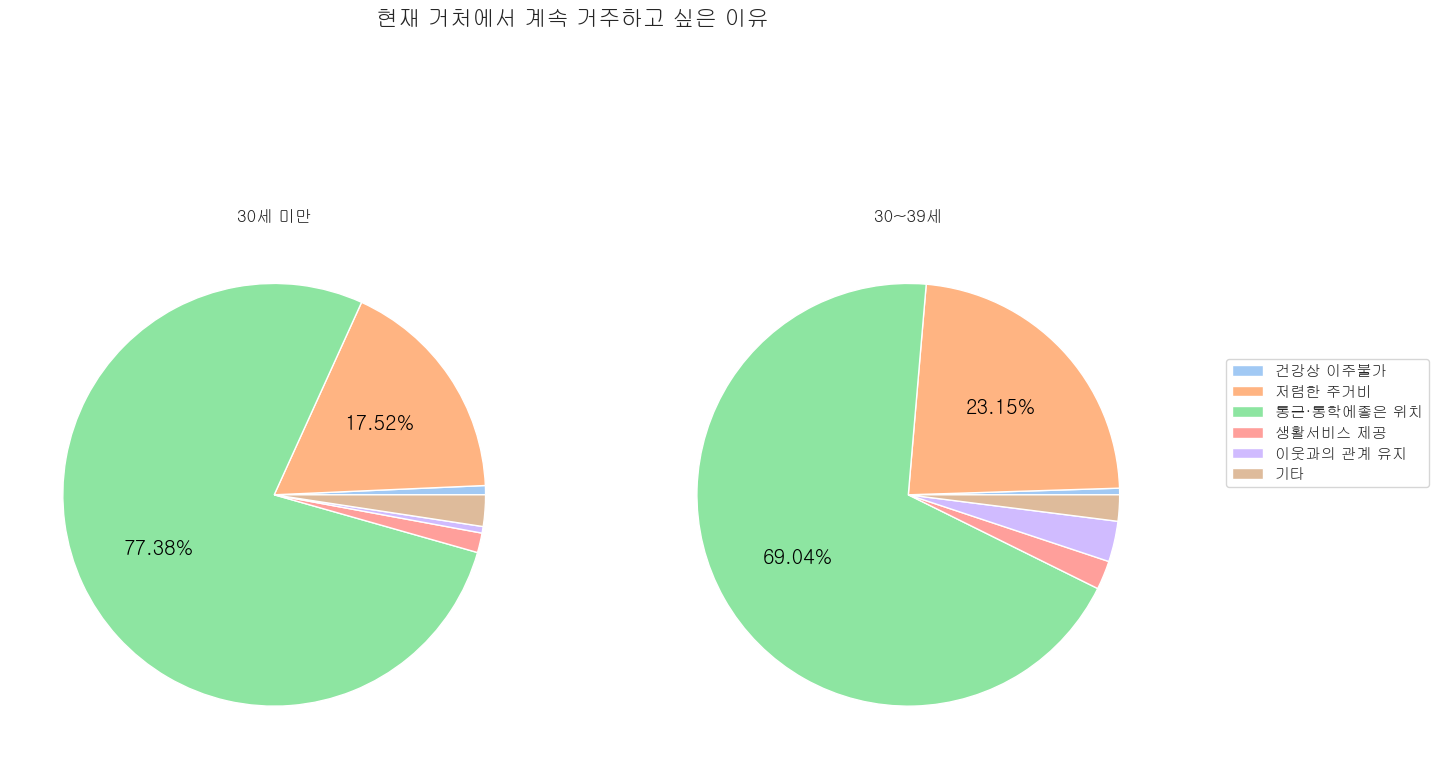

In [24]:
why_now_house_ing = read_csv('data/survey/현재_거처에서_계속_거주하고_싶은_이유_20210722170138.csv')
fig, ax = draw_two_pie(why_now_house_ing, 24, 25, 3, "현재 거처에서 계속 거주하고 싶은 이유")
fig

현 거처를 선택한 이유를 뒷받침하는 결과로써,
**현재 거처에서 거주하고 싶은 이유**도 70%가 넘는 사람들이 통근·통학에 좋은 위치라고 답했습니다

이는 통근·통학지와 **접근성이 좋은 주거지를
선호**한다고 볼 수 있습니다. 

#### <주거취약계층의 이주 계획 이유>

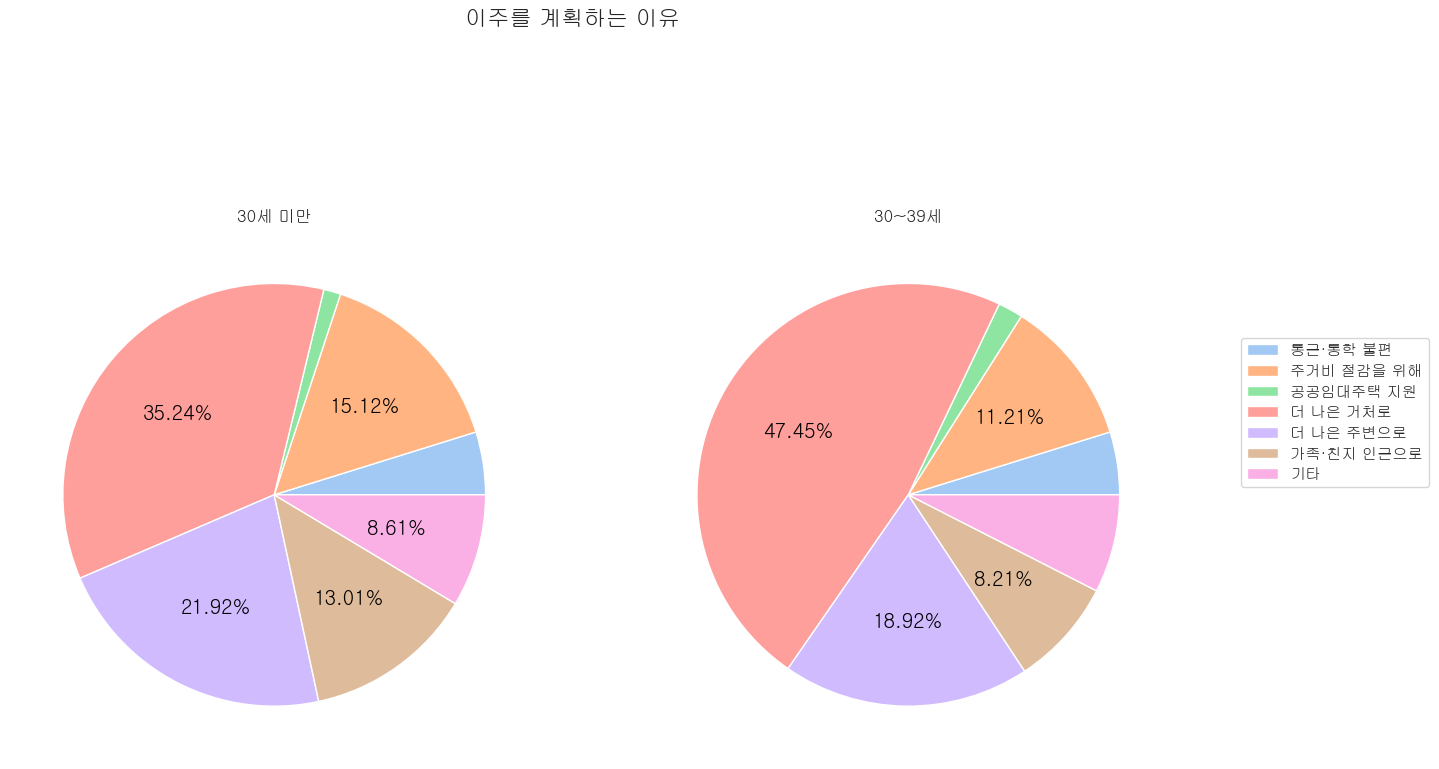

In [25]:
why_move = read_csv('data/survey/이주를_계획하는_이유_20210722170153.csv')
fig, ax = draw_two_pie(why_move, 24, 25, 3, "이주를 계획하는 이유")
fig

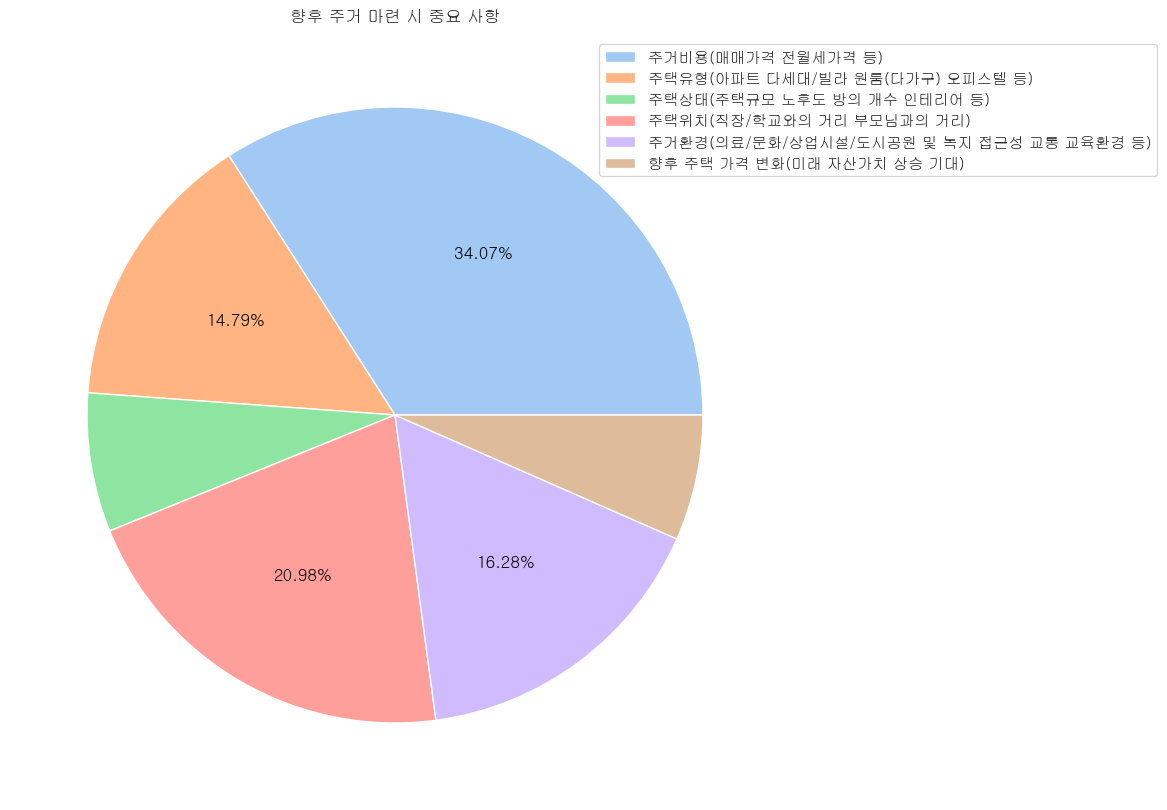

In [26]:
house_important = read_csv('data/survey/향후_주거_마련_시_중요사항_20210722165336.csv')
plt.close("all")
plt.figure(figsize=(15,10))
plt.pie(house_important.iloc[1,2:], autopct=my_autopct, textprops=dict(color='black'))
plt.title("향후 주거 마련 시 중요 사항")
plt.legend(house_important.iloc[0,2:], loc='lower right', bbox_to_anchor=(1.5,0.8))
plt.show()

통근·통학이 편리한 서울권 내에 거주하는 청년들은 주거 환경보다 접근성을 택한 것이기 때문에 **더 나은 거처**로 이주하고 싶다는 응답이 높게 나타납니다.

또한, 접근성과 더불어 **경제성을 고려**하는 청년 세대의 주거 마련 시 고려하는 중점을 살펴볼 수 있습니다.

### c. 공공임대주택 인식

 위에서 살펴본 것처럼 청년 세대는 주거비에 많은 부담을 느끼고 있습니다. 청년 세대는 정부가 어떤 정책을 펼쳐 이런 주거 문제를 해결하기를 원할까요?

In [27]:
house_policy_data = read_csv('data/survey/청년_주거_정책_인지도_및_가장_시급한_청년_주거_정책_20210722165342.csv')
policy_pop = house_policy_data.iloc[:3,2:6]
policy_hurry = house_policy_data.iloc[:3,6:]

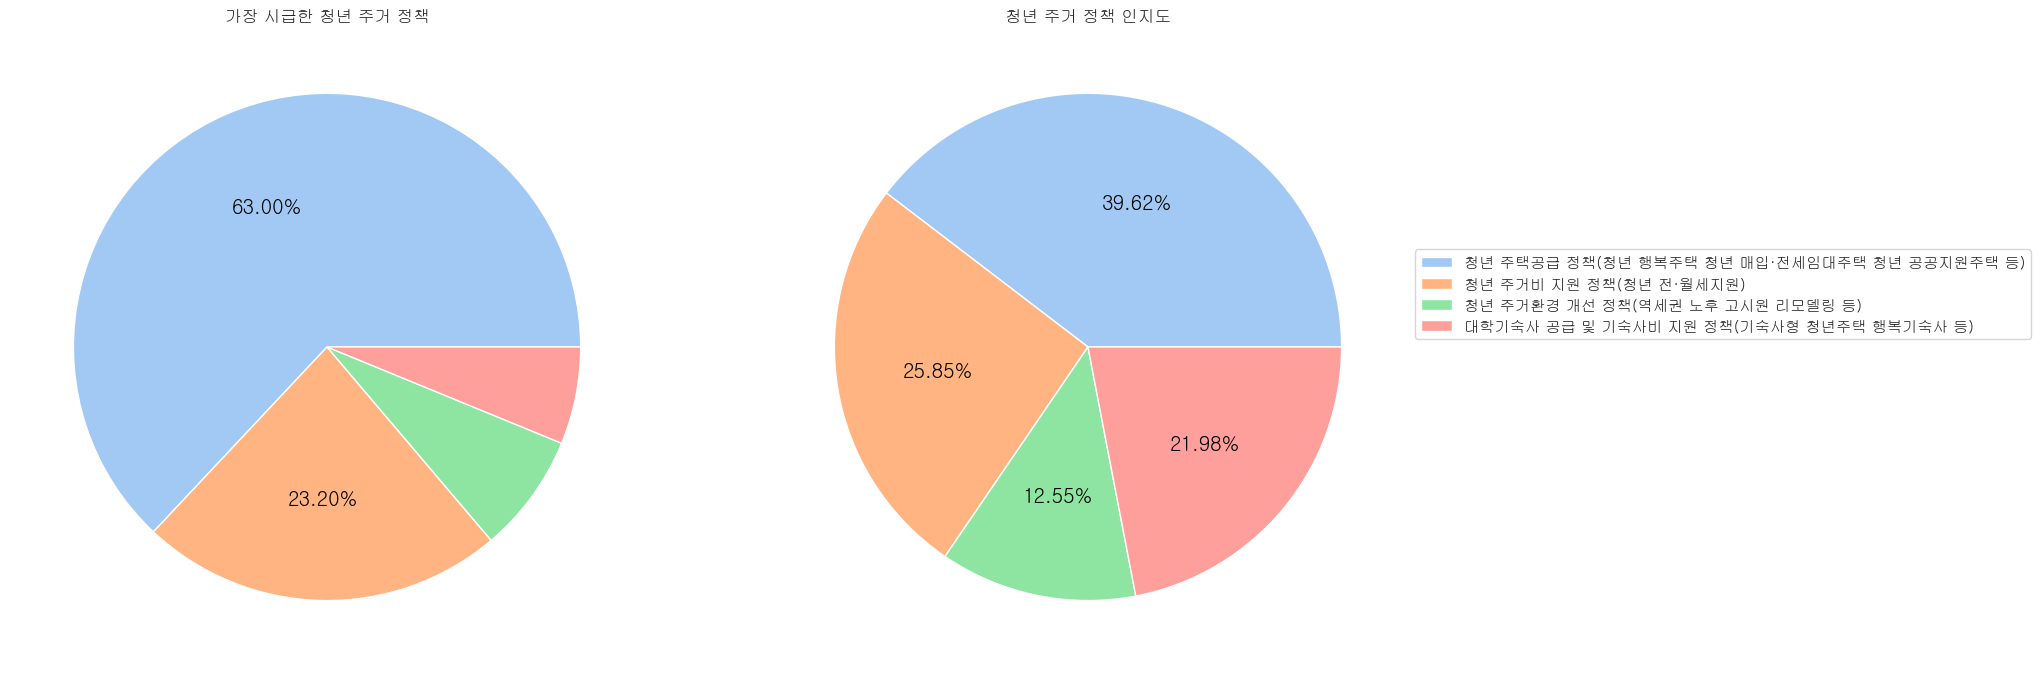

In [28]:
fig, ax = plt.subplots(1,2, figsize=(18,10))
ax[0].pie(policy_hurry.iloc[2], autopct=my_autopct, textprops=dict(color='black', size='large'))
ax[0].set_title(policy_hurry.iloc[0,0])
ax[1].pie(policy_pop.iloc[2], autopct=my_autopct, textprops=dict(color='black', size='large'))
ax[1].set_title(policy_pop.iloc[0,0])
ax[1].legend(policy_pop.iloc[1], loc='lower right', bbox_to_anchor=(2,0.5))
plt.show()

청년들이 가장 시급하다고 꼽은 주거 정책은 **청년 주택 공급**으로, 과반수 이상의 청년들이 청년 행복주택이나 매입·전세임대주택의 필요성을 드러냈습니다. 

또한, 청년 주택공급 정책, 주거비 지원 정책, 대학 기숙사 공급 순으로 인지도가 높음을 확인할 수 있습니다. 

그리고 **주택 공급 정책이 가장 인지도가 높은 정책**이었습니다.

주택 공급 정책은 **이미 시행되는 정책이고 사람들이 잘 알고있는 정책인데 왜 청년들은 가장 시급한 정책으로 주택공급 정책을 선택한 것일까요?**

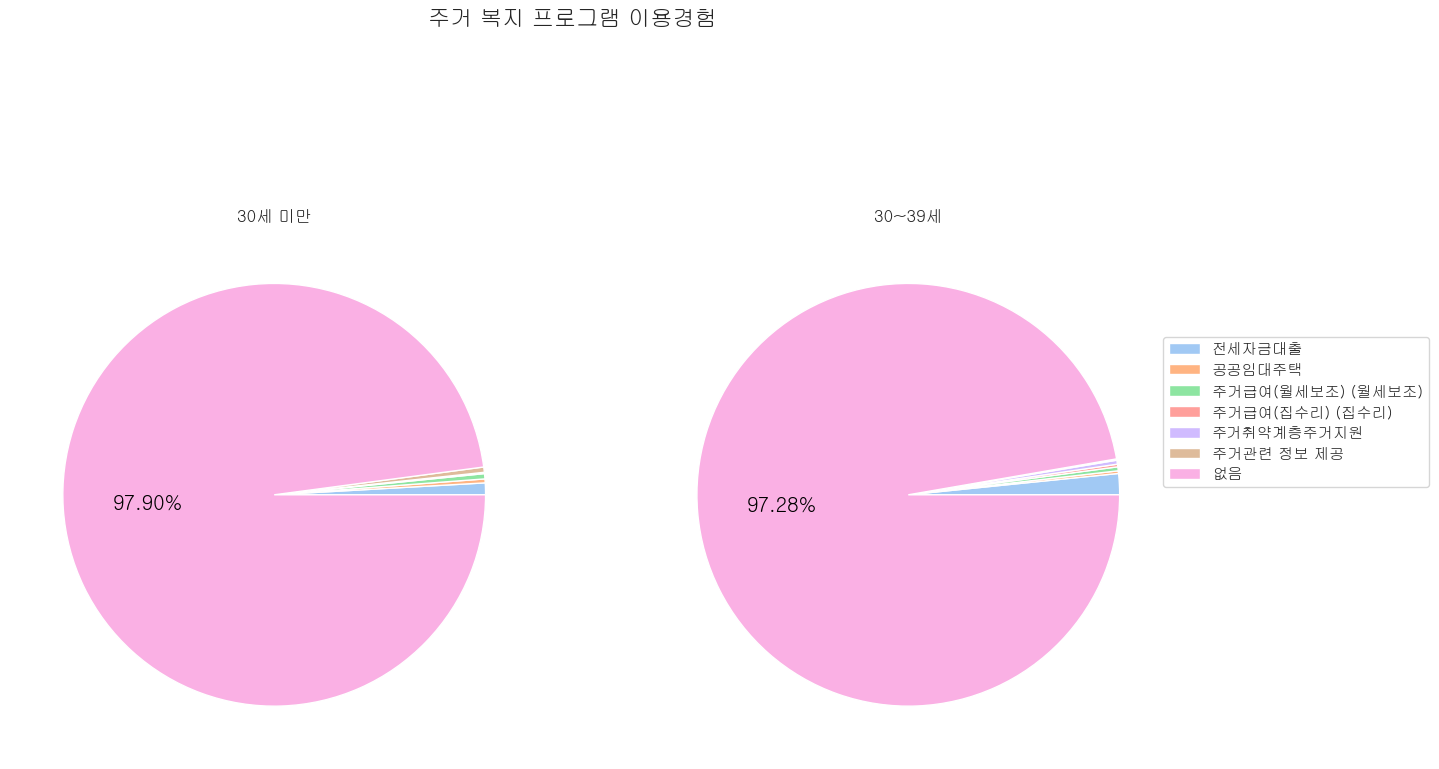

In [29]:
cant_use_policy = read_csv('data/survey/주거복지_프로그램_이용_경험_20210722170214.csv')
fig, ax = draw_two_pie(cant_use_policy, 19, 20, 4, "주거 복지 프로그램 이용경험")
fig

위 그래프는 주거 취약 계층의 주거 복지 프로그램 이용 경험에 대한 설문 결과입니다.

주택 이외의 거처에서 생활하는 주거 취약 계층임에도 불구하고 **주거 복지 프로그램의 이용 경험은 없는** 경우가 대부분입니다. 

이는 다음과 같은 결과와 연결됩니다.

![공실](https://github.com/victolee0/dacon/blob/master/blank_house.png?raw=true)

계속되는 공공임대주택 공급 속에도 3개월 이상 빈집으로 남아있는 현황으로 미루어 보자면, 대중교통이 편리한 지역에 저렴하면서 양질의 주택을 공급하고자 하는 목표가 원 계획과 달리 여러 가지 현실적인 문제에 봉착했음을 알 수 있습니다. 

위에서 살펴본 파이 차트의 결과들로 미루어 볼 때, 이런 현실은 공공임대주택이 사람들이 **집을 고르는 기준(통근·통학 접근성)을  충족시키지 못했기 때문**이라고 판단하였습니다. 

따라서 본 분석은 공공임대주택의 입지로 일반적으로 사람들이 중요하게 여겼던 **통근·통학하기 좋은 위치를 선정**해 보고자 합니다.

## 본론 2
### a. 수요지 데이터 생성
앞서 설명했듯, 본 분석에서는 **통근, 통학**하기 좋은 행복주택 입지를 선정하고자 합니다.  

따라서 서울시의 **주요 고용 중심지**, **대학 소재지**를 수요지로 고려하여 입지 후보지의 접근성을 살펴볼 계획입니다.



#### <1. 통근 발생 수요지>

In [44]:
seoul_work = pd.read_excel('data/서울시 사업체 및 종사자 밀도 (동별) 통계.xlsx')

위 데이터는 서울시 전체 인구를 대상으로 하는 데이터입니다.  

본 분석은 청년을 대상으로 하기 때문에 위 데이터에 서울시의 청년 경제활동 인구 비율을 곱해주어 사용할 것 입니다.

[한국여성정책연구원](https://gsis.kwdi.re.kr/statHtml/statHtml.do?orgId=338&tblId=DT_1DA7012&vw_cd=undefined&list_id=undefined&scrId=&seqNo=&language=ko&obj_var_id=undefined&itm_id=undefined&conn_path=I2&path=)의 조사 결과 총 경제 인구 2873만명 중 20~29세의 경제 활동 인구 수는 413만명으로 약 0.14의 비율이라고 합니다.  

따라서 데이터의 값에 0.14를 곱해주어 청년 종사자의 수로 대체할 것입니다.


In [45]:
del_sum = seoul_work[seoul_work['동'] == '소계'].index
seoul_work = seoul_work.drop(del_sum)
seoul_work = seoul_work.drop(index=0)

In [46]:
seoul_work_top10 = seoul_work.sort_values(by="종사자수", ascending=False).head(10)
seoul_work_top10 = seoul_work_top10.drop(['평균종사자', '사업체밀도', '종사자밀도(A)','인구밀도(B)','종사자밀도비(A/B*100)'], axis=1)

In [47]:
#서울시 주요 고용 중심지 상위 10곳
seoul_work_top10['20~29세 종사자수(명)']= round(seoul_work_top10['종사자수'].mul(0.14))

#### <2. 통학 발생 수요지>

In [48]:
#대학교 소재 및 기숙사 수용 현황
univ = pd.read_csv('data/기숙사 수용 현황 (대학).csv', encoding='cp949')

In [49]:
seoul_univ = univ[univ['지역']=='서울']
seoul_univ = seoul_univ.drop(['상태', '총 실수', '수용가능인원(B)', 'Unnamed: 10', 'Unnamed: 11', '기숙사 지원자 수(D)', 'Unnamed: 14', 'Unnamed: 15', '입사 경쟁률\n(E=D/B)',
                              '의무식\n여부', '구분', '건물명','준공연도', '1인실', 'Unnamed: 22', '2인실', 'Unnamed: 24', '3인실', 'Unnamed: 26','4인실 이상', 'Unnamed: 28',
                              '실제 수용 인원'], axis=1)
seoul_univ = seoul_univ.rename(columns={'기숙사수용률\n(C=B/Ax100)':'기숙사 수용률', '재학생수(A)':'재학생 수'})
seoul_univ = seoul_univ.drop_duplicates()

In [50]:
seoul_univ.head(10)

,기준연도,학교종류,설립구분,지역,학교,재학생 수,기숙사 수용률
23,2020.0,대학교,사립,서울,가톨릭대학교 _제2캠퍼스,"1,548",7.8
24,2020.0,대학교,사립,서울,가톨릭대학교 _제3캠퍼스,285,107.4
28,2020.0,대학교,사립,서울,감리교신학대학교,"1,403",21.4
58,2020.0,대학교,사립,서울,건국대학교,"17,518",18.9
75,2020.0,대학교,사립,서울,경기대학교 _제2캠퍼스,"2,607",0.0
150,2020.0,대학교,사립,서울,경희대학교,"28,793",20.6
172,2020.0,대학교,사립,서울,고려대학교,"26,307",10.8
205,2020.0,대학교,사립,서울,광운대학교,"8,631",12.4
226,2020.0,대학교,사립,서울,국민대학교,"15,922",11.7
329,2020.0,대학교,사립,서울,덕성여자대학교,"5,629",15.3


**수요량(명) = 재학생 x (1-기숙사 수용률)**

대학생의 수요량은 위 식을 이용해서, 기숙사에 들어가지 못해 통학이 필요한 재학생의 수를 계산하여 파악하였습니다.  

In [51]:
seoul_univ['non_accept'] = 100 - seoul_univ['기숙사 수용률']
seoul_univ['수요량(명)'] = round((seoul_univ['재학생 수'].apply(lambda x: x.replace(',','')).astype('int') * seoul_univ['non_accept'])/100)

In [52]:
# 기숙사 수용률 100% 초과인 가톨릭대학교_제3캠퍼스 수요지에서 제외
seoul_univ = seoul_univ[seoul_univ.학교 != '가톨릭대학교 _제3캠퍼스']

In [53]:
# 명지대학교 제2캠퍼스 => 정식 명칭상 명지대학교 자연캠퍼스로 변경
seoul_univ = seoul_univ.replace({'학교': '명지대학교 _제2캠퍼스'}, {'학교': '명지대학교 자연캠퍼스'})

#### <수요량 분포>
: 수요지인 주요 고용 중심지와 대학 소재지의 수요량을 지도 위에 분포로 시각화

In [133]:
seoul_univ = pd.read_csv('data/seoul_univ.csv')
seoul_work_top10 = pd.read_csv('data/seoul_work_top10.csv')

In [134]:
tmp0 = seoul_univ[["학교","위도","경도",'수요량(명)']].rename(columns={"학교":"이름"})
tmp0['type'] = '대학'

In [135]:
tmp1 = seoul_work_top10[['동','위도','경도', '20~29세 종사자수(명)']].rename(columns={"동":"이름", '20~29세 종사자수(명)':'수요량(명)'})
tmp1['type'] = '고용중심지'

In [136]:
df = pd.concat([tmp0, tmp1], axis=0, ignore_index=True)

In [137]:
fig = px.scatter_mapbox(df,lat='위도',lon='경도',
                        center = {"lat": 37.5, "lon": 126.9},zoom=9,
                        size = '수요량(명)', color = 'type'
                       )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(mapbox_style="carto-positron")
fig

- 대학의 경우, 수요량이 수도권 전반에 걸쳐 **골고루 퍼져있는 양상**을 보인다.
또한, 수요량은 **학교별로 큰 편차**를 보입니다.
이는 학교의 유형과 규모에 따라 재학생 수가 다를 뿐 아니라,
기숙사 수용률에서도 현저한 차이를 보이기 때문입니다. 

- 반면 고용중심지의 경우, 수요량이 주로 
서울 **서남, 동남, 중부에 치우친 경향**을 보입니다.

### b. 후보지 데이터 소개
#### <후보지 선정 배경>

![후보지](https://github.com/victolee0/dacon/blob/master/%ED%94%BC%ED%94%BC%ED%8B%B0_%ED%9B%84%EB%B3%B4%EC%A7%80.png?raw=true)

### c. 해제구역의 괴리율
#### <해제구역의 괴리율>

![괴리율](https://github.com/victolee0/dacon/blob/master/%ED%94%BC%ED%94%BC%ED%8B%B0_%EA%B4%B4%EB%A6%AC%EC%9C%A8.png?raw=true)

In [30]:
# 공시지가 데이터 불러오기 & 전처리
def realtrade(file_name):
    data = pd.read_csv(file_name, encoding='cp949',dtype={'고유번호': 'str'})
    data = data[data.기준연도 == 2020]
    data = data.assign(주소 = data.법정동명 +' '+ data.지번)
    data = data.assign(동 = data.법정동명.str.split().str[-1]) # 괴리율 계산할 때 행정동 추출용
    return data

In [31]:
#서울, 인천, 경기의 공시지가
seoul = realtrade('data/AL_11_D151_20210608.csv')
incheon = realtrade('data/AL_28_D151_20210608.csv')
gyunggi = realtrade('data/AL_41_D151_20210608.csv')

In [32]:
#괴리율 계산을 위한 작업
price = pd.read_excel('data/해제구역 공시지가.xlsx')
a = price[price.시=='서울시'].reset_index()
b = price[price.시=='인천광역시'].reset_index()
c = price[~price.시.isin(['서울시','인천광역시'])].reset_index()

#서울특별시 동 추출
tmp1=[]
for i in range(len(a.지번)):
    tmp1.append(a.지번[i].split()[0])    
ads_seoul = pd.DataFrame(tmp1)[0].unique() 

#인천광역시 동 추출
tmp2=[]
for i in range(len(b.지번)):
    tmp2.append(b.지번[i].split()[0])    
tmp2[19]= '용현동'
tmp2[20] = '숭의동'
tmp2[25] = '주안동'
tmp2[30]= '주안동'
tmp2[35]= '주안동'
tmp2[39]= '주안동'
ads_incheon = pd.DataFrame(tmp2)[0].unique()
# 행정동 공시지가 데이터에 '금창동',용현1동','숭의4동','주안2동', '주안5동'은 없음 
#'금창동'-> '금곡동' &  '창영동' (두개가 통합된 행정동) -> 후에 둘의 평균 추가
# 나머지 -> '용현동','주안동','숭의동'으로 수정 


#경기도 동/리 추출
tmp3=[]
for i in range(len(c.지번)):
    tmp3.append(c.지번[i].split()[-2])
ads_gyunngi = pd.DataFrame(tmp3)[0].unique()

In [33]:
#최종 행정동과 일치하는 데이터 추출
gongsi_seoul = seoul[seoul.동.isin(ads_seoul)][['공시지가','동']]
gongsi_gyunggi = gyunggi[gyunggi.동.isin(ads_gyunngi)][['공시지가','동']]
gongsi_incheon = incheon[incheon.동.isin(ads_incheon)][['공시지가','동']]

In [34]:
#지역별로 Groupby
grouped_seoul = gongsi_seoul['공시지가'].groupby(gongsi_seoul['동'])
grouped_gyunggi = gongsi_gyunggi['공시지가'].groupby(gongsi_gyunggi['동'])
grouped_incheon = gongsi_incheon['공시지가'].groupby(gongsi_incheon['동'])

In [35]:
# 지역별 행정동 평균공시지가
gongsi_mean_seoul = pd.DataFrame(grouped_seoul.mean()) #84 
gongsi_mean_gyunggi = pd.DataFrame(grouped_gyunggi.mean()) #12
gongsi_mean_incheon = pd.DataFrame(grouped_incheon.mean()) #30 금창동 빼고

In [36]:
#서울,경기,인천 통합 공시지가 데이터 생성
gongsi = pd.concat([gongsi_mean_gyunggi,gongsi_mean_incheon,gongsi_mean_seoul])
price = price.assign(동 = tmp1 + tmp2 + tmp3)
gap = pd.merge(price,gongsi,how='outer',on='동')
gap = gap.rename(columns=({'공시지가_x':'해제구역 공시지가','공시지가_y':'해당 행정동 공시지가'}))

#금창동 데이터 추가
gapr = gap.copy() #데이터 수정하기 위해 복사
gapr.loc[187,'해당 행정동 공시지가']=(4.930559e+05 + 7.636815e+05)/2 # 금곡동과 창영동의 공시지가 평균

#괴리율 = 해제구역 공시지가 / 소속 행정동 평균 공시지가
gapr = gapr.assign(괴리율 = gapr['해제구역 공시지가'] / gapr['해당 행정동 공시지가'])

In [37]:
gapr.괴리율.isna().sum() # nan 없음!

0

In [38]:
gapr.괴리율.isnull().sum() #null 없음!

0

In [39]:
#구글API로 해제구역 좌표 가져오기
lat = []
lng = []
gmaps = googlemaps.Client(key='')
for name in gapr['지번']:
    try:
        tmpMap = gmaps.geocode(name, language = 'ko')
        tmpLoc = tmpMap[0].get('geometry')
        lat.append(tmpLoc['location']['lat'])
        lng.append(tmpLoc['location']['lng'])
    except:
        print('{} Address Error'.format(name))
        lat.append(None)
        lng.append(None)

gapr['위도'] = lat
gapr['경도'] = lng

유동 14-5 Address Error
전동 15-1 Address Error


In [40]:
#유동 14-5, 전동 15-1 오류여서 직접 수정
gaprr = gapr.copy() #데이터 수정하기 위해 복사

gaprr.loc[177,'위도'] = 37.46927628322808
gaprr.loc[177,'경도'] = 126.63755636219985
gaprr.loc[180,'위도'] = 37.47783487999146
gaprr.loc[180,'경도'] = 126.62781501161263


In [138]:
#plotly로 해제구역 괴리율을 지도에 표시
fig = px.scatter_mapbox(gaprr,lat='위도',lon='경도',hover_name='지번',
                        hover_data=['괴리율','동'],color="괴리율",
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        range_color=[0,3],
                        center = {"lat": 37.5, "lon": 126.9},zoom=9
                       )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(mapbox_style="carto-positron")

In [42]:
(gaprr.괴리율>1).sum()

231

In [43]:
gaprr[gaprr.괴리율>2]

,시,구,지구명,구역명,지번,해제구역 공시지가,동,해당 행정동 공시지가,괴리율,위도,경도
53,서울시,성북구,NaN,월곡7,하월곡동 81-450,6247000,하월곡동,3.079078e+06,2.028854,37.610120,127.033112
68,서울시,노원구,NaN,월계동 39-1,월계동 39-1,4301000,월계동,1.887728e+06,2.278400,37.615550,127.066187
193,인천광역시,미추홀구,NaN,제물포북부역,도화동 80-94,2402000,도화동,1.177105e+06,2.040599,37.467498,126.654774
257,김포시,양곡,양곡,NaN,양촌면 양곡리 461,1483000,양곡리,5.237423e+05,2.831545,37.657430,126.621842
258,남양주시,퇴계원,퇴계원,NaN,남양주시 퇴계원면 퇴계원리 269-14,2805000,퇴계원리,9.096494e+05,3.083606,37.654102,127.140479


- 269개의 해제구역 중 무려 231개가 1보다 큰 괴리율을 가져 소속 행정동보다 높은 공시지가를 가지고 있음이 밝혀졌고, 그 중 남양주시 ‘퇴계원’구역은 주변보다 3배가 높은 공시지가를 가지고 있습니다.

- 대다수의 해제구역이 비싼 공시지가를 가진 것으로 보아, 해제구역이 재개발지역에서 해제되는 이유에는 **경제적인 부담의 영향**도 존재한다고 추론해 볼 수 있습니다. 즉, 국가 차원에서 실행되는 재개발 사업의 경우 **경제성이 중요한 고려사항**임을 알 수 있습니다. 

- 이에 본 분석에서는 행복주택의 우선 입지를 선정함에 있어서 단순히 **접근성만 고려하는 것이 아니라 경제성**도 고려하고자 합니다.

### d. 경제성 & 접근성 계산

#### <공시지가로 경제성 계산>

앞서 괴리율에서 살펴보았듯이, **경제성은 국가사업에 있어서 중요한 고려사항** 중 하나입니다.

따라서, 단순히 접근성만을 고려하는 기존 K-median 방법과는 달리 본 분석에서는 보다 현실성 있는 행복주택 입지선정을 위해 행복주택 사업에 드는 비용까지 고려하고자 합니다.  

이를 위해 공시지가 데이터를 활용하여 행복주택 사업에 드는 기본적인 비용을 산출했습니다. 

보다 현실적인 계산을 위해 건축비나 실거래가도 고려하는 방법도 있지만, 사업에서 비용이 가장 많이 드는 부분은 토지 매입비용이고 [공시지가는 실거래가와 0.65:1 정도로 비례하는 관계를 갖기 때문에](https://www.krihs.re.kr/publica/reportView.do?num=3607971) **공시지가만으로도 충분히 경제성을 고려**할 수 있어 공시지가 데이터를 사용하였습니다.

*참고사이트*
- : https://www.realtyprice.kr:447/notice/gsstandard/search.htm

*계산방법*
- 1. 서울/경기/인천 해제구역의 지번 주소를 기준으로 공시지가를 열람합니다.
- 2. 해당 주소의 공시지가가 부재일 경우, 지도를 확인해 근접 지번의 평균 공시지가로 대체합니다.
- 3. 해당 구역의 주위환경을 고려해, '주택지대'의 공시지가를 가져오고 '상가지대'는 배제합니다.

#### <대중교통 소요 시간을 통한 접근성 계산> 

본 분석의 정책 대상이 통근⋅통학을 하는 청년이기 때문에,자동차를 이용했을 때 걸리는 시간을 이용하는 것 보다는 **대중교통 소요시간**을 이용하는 것이 합리적이라 판단했습니다.

구글API 활용을 통해 **환승이나 도보로 걷는 시간 등 세부적인 소요시간**까지 계산할 수 있기에 **객관적인 접근성**을 계산할 수 있었습니다.

In [ ]:
# 서울 후보지와 대학 대중교통 시간
data = pd.read_excel('data/해제구역 공시지가.xlsx')
univ = pd.read_csv('data/기숙사 수용 현황 (대학).csv', encoding='cp949')
seoul_univ = univ[univ['지역']=='서울']
seoul_univ = seoul_univ.drop(['상태', '총 실수', '수용가능인원(B)', 'Unnamed: 10', 'Unnamed: 11', '기숙사 지원자 수(D)', 'Unnamed: 14', 'Unnamed: 15', '입사 경쟁률\n(E=D/B)',
                              '의무식\n여부', '구분', '건물명','준공연도', '1인실', 'Unnamed: 22', '2인실', 'Unnamed: 24', '3인실', 'Unnamed: 26','4인실 이상', 'Unnamed: 28',
                              '실제 수용 인원'], axis=1)
seoul_univ = seoul_univ.rename(columns={'기숙사수용률\n(C=B/Ax100)':'기숙사 수용률', '재학생수(A)':'재학생 수'})
seoul_univ = seoul_univ.drop_duplicates()
cols = [i.strip() for i in seoul_univ['학교']]
idx = data['지번']
univ_time_df = pd.DataFrame(index=idx)

In [ ]:
api_key = ''

for school in tqdm(cols):
    tmp = []
    for i in idx:
        start = i
        try:
            distance, hours = with_bus(start, school.strip(), api_key)
        except:
            print(f'error: {i}')
            hours = {'text':""}
        tmp.append(hours["text"])
    univ_time_df[school] = tmp

In [ ]:
lst = data['지번']
work_time_df = pd.DataFrame(index = lst)
for school in tqdm(seoul_work_top10['동']):
    tmp = []
    for i in work_time_df.index:
        start = i
        try:
            distance, hours = with_bus(start, school.strip(), api_key)
        except:
            print(f'{i} error')
            hours = {'text':""}
        tmp.append(hours["text"])
    work_time_df[school] = tmp

  0%|          | 0/10 [00:00<?, ?it/s]

유동 14-5 error
전동 15-1 error
오산시 오산동 330 error
유동 14-5 error
전동 15-1 error


In [ ]:
tmp_df = pd.concat([univ_time_df, work_time_df])

In [ ]:
tmp_df.to_csv('data/time_matrix.csv', encoding='utf-8-sig')

본 분석에서는 접근성을 고려하기 위해 **google map api**를 이용하여 대중교통을 이용했을 때 걸리는 시간을 이용하였습니다.

*api를 이용했을 때 error가 나오는 경우 직접 확인 및 수정을 해주었습니다.*

## 4. 입지 선정 
### a. 다목적 공간 최적화 모델
#### <다목적 공간 최적화 정의>

    
본격적으로 입지 선정을 해보고자 합니다.  

입지 선정은 본 분석에서 접근성과 경제성을 함께 고려하여 설정한 **다목적 공간 최적화 함수를 최소화**하는 최적값을 찾는 방식으로 진행됩니다.

![다목적](https://github.com/victolee0/dacon/blob/master/%ED%94%BC%ED%94%BC%ED%8B%B0_%EB%8B%A4%EB%AA%A9%EC%A0%81.png?raw=true)

In [44]:
data = pd.read_excel('data/수요지후보지 시간.xlsx', index_col=0)
price = pd.read_excel('data/해제구역 공시지가.xlsx')

In [45]:
#min, hour을 초로 바꾸기
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        data.iloc[i][j] = [num for num in data.iloc[i][j].split() if num not in ['hour', 'hours', 'mins', 'min']]
        tmp = 0
        for k in range(len(data.iloc[i][j])):
            idx = k+1 
            tmp += int(data.iloc[i][j][-idx]) * (60**idx)
        data.iloc[i][j] = tmp
data=data.astype('float')

In [46]:
# 시간과 거리를 함께 고려하기 위해서 scale을 맞춰주기
sc=StandardScaler()
a=pd.DataFrame(sc.fit_transform(price.공시지가[:,np.newaxis]))

In [47]:
sce=StandardScaler()
b=pd.DataFrame(sce.fit_transform(data))

#### <다목적 공간 최적화 모델>

![모델](https://github.com/victolee0/dacon/blob/master/%ED%94%BC%ED%94%BC%ED%8B%B0_%EB%AA%A8%EB%8D%B8.png?raw=true)

행복주택 사업 기획에 있어 접근성과 경제성을 함께 고려할 때, 사업자가 **주관이나 현실적인 제약에 따라** 접근성과 경제성 둘 중 **한 쪽에 치중해야 하는 상황**이 생길 수 있습니다.  

따라서 본 분석은 사업자가 어느 쪽에 얼마나 더 주안점을 두는지에 따른 모든 경우를 고려하고자 가중치 w를 두었습니다.  

가중치 w가 **클수록 접근성에 치중하는 것**을 의미하고, **작을수록 경제성에 초점을 더 두는것**을 의미합니다.

### b. K-median 입지 선정 알고리즘

![수식](https://github.com/victolee0/dacon/blob/master/%ED%94%BC%ED%94%BC%ED%8B%B0_%EC%88%98%EC%8B%9D.png?raw=true)

In [51]:
def kmedian(I,J,c,p,w,k):

    #Parameters:
    #    - I: set of customers(수요지)
    #    - J: set of potential facilities(후보지)
    #    - c[i,j]: i와 j 사이의 거리
    #    - k: number of facilities to be used
    #    - lc[j]: 공시지가
    #    - w : 가중치
            
    model = Model("k-median")
    x,y = {},{}
    # 목적함수에서 사용할 변수 추가
    # 제약조건 4
    for j in J:
        y[j] = model.addVar(vtype="B", name="y(%s)"%j)
        for i in I:
            x[i,j] = model.addVar(vtype="B", name="x(%s,%s)"%(i,j))

    for i in I:
        # 제약조건 1
        model.addCons(quicksum(x[i,j] for j in J) == 1, "Assign(%s)"%i)
        for j in J:
            # 제약조건 3
            model.addCons(x[i,j] <= y[j], "Strong(%s,%s)"%(i,j))
    # 제약조건 2
    model.addCons(quicksum(y[j] for j in J) == k, "Facilities")
    
    # 목적함수
    model.setObjective(quicksum(w*c[i,j]*x[i,j] + (1-w)*p[j]*x[i,j]  for i in I for j in J) , "minimize")
    model.data = x,y

    return model


In [52]:
idx = b.index
cols = b.columns

In [53]:
# 시간거리 데이터를 최적화 함수에서 사용할 수 있도록 변환
EPS= -1
c = {}
I = range(len(cols))
J = range(len(idx))
for i in I:
    for j in J:
        c[i,j] = b.iloc[j,i]       
lc = a[0].transpose()

#### <최적의 K값>

In [54]:
# 최적의 K값 정하기
score = []
weight = []
k = []
for i in range(1,10):
    for j in range(0,11):
        model = kmedian(I, J, c,lc,j/10, i)
        model.optimize()
        x, y = model.data
        EPS = 1.e-6
        edges = [(i,j) for (i,j) in x if model.getVal(x[i,j]) > EPS]
        facilities = [j for j in y if model.getVal(y[j]) > EPS]
        score.append(model.getObjVal())
        weight.append(j/10)
        k.append(i)


In [55]:
score_df=  pd.DataFrame([weight, k, score]).T.rename(columns={0:'가중치',1:'k',2:'score'})

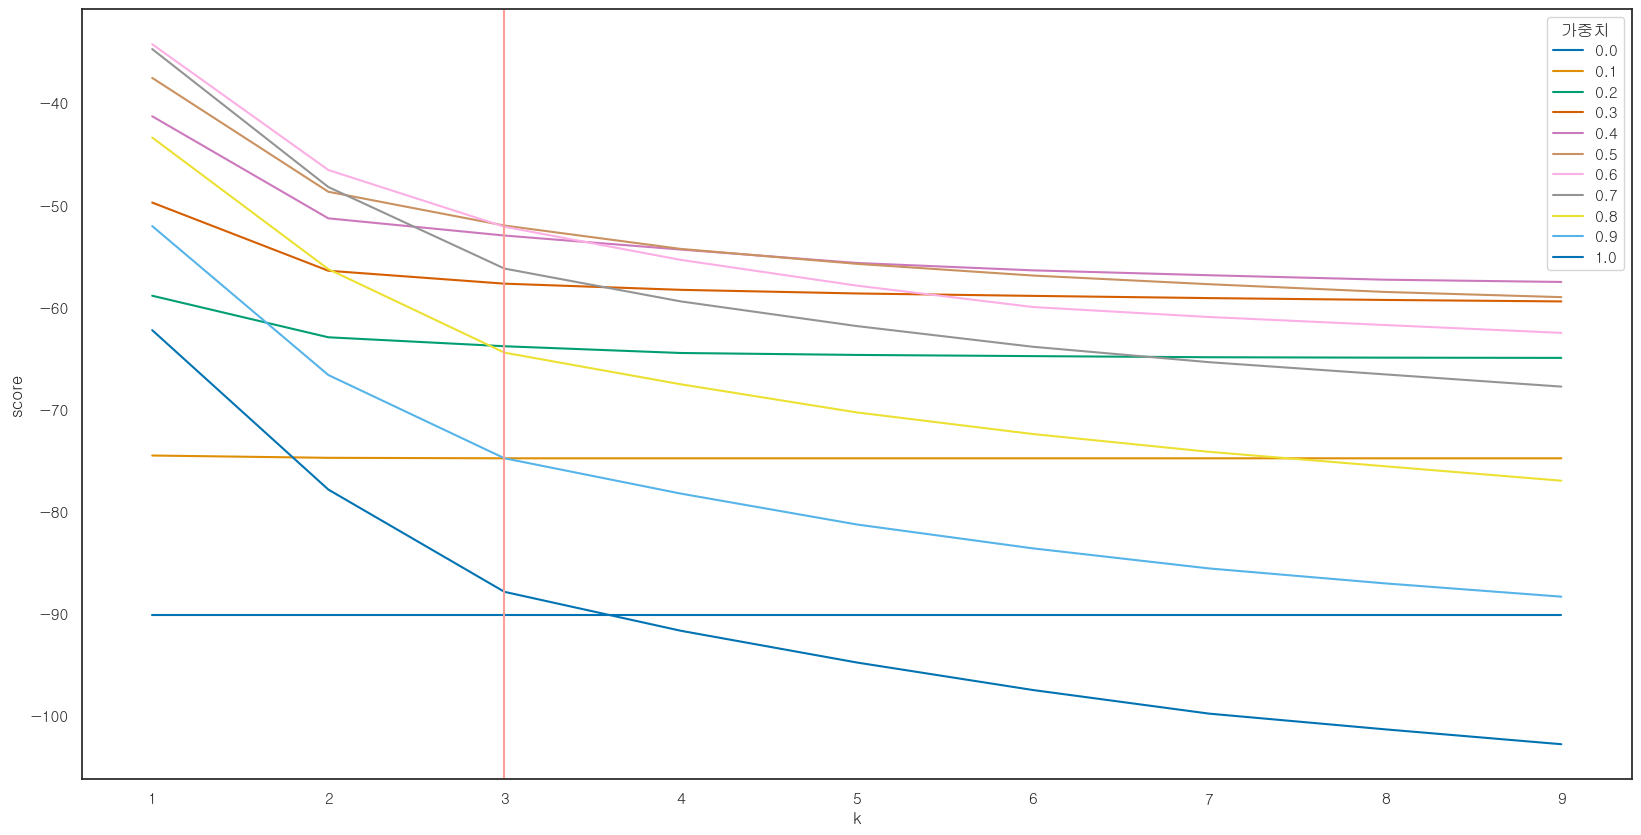

In [56]:
plt.subplots(figsize=(20,10))
fig = sns.lineplot(data=score_df, x='k', y='score', hue='가중치', palette='colorblind')
plt.xticks(range(1,10))
plt.axvline(3, c='r')
plt.show()

본 분석은 단순히 몇 개의 입지를 선정할지 임의로 정하는 것이 아니라, 
가중치 별로 K가 달라짐에 따라 계산된 목적함수 값을 그래프로 나타내어 최적의 K를 찾고자 합니다. 

그래프에서 나타난 것과 같이, 대체적으로 K=3일 때 **elbow point**를 가짐에 따라
본 분석에서는 **3개의 입지**를 선정하기로 결정했습니다. 

### c. 최종 결과
#### <가중치 변화에 따른 최종 입지>

In [57]:
# 가중치 별 최적 입지 찾기
res = {}
edge = {}
score = {}
for i in range(0, 11):
    model = kmedian(I, J, c,lc,i, 3)
    model.optimize()
    x, y = model.data
    EPS = 1.e-6
    edges = [(i,j) for (i,j) in x if model.getVal(x[i,j]) > EPS]
    facilities = [j for j in y if model.getVal(y[j]) > EPS]
    res[i/10] = facilities
    print(i/10, model.getObjVal(), facilities)
    edge[i/10] = edges
    score[i/10] = model.getObjVal()

0.0 -90.15402207348056 [51, 52, 266]
0.1 -87.85719716309728 [33, 92, 170]
0.2 -323.36898881324885 [53, 142, 171]
0.3 -573.1940190407536 [95, 142, 171]
0.4 -824.9377012835027 [95, 142, 171]
0.5 -1076.893531028038 [95, 142, 171]
0.6 -1329.008633825987 [95, 142, 171]
0.7 -1581.1297073791948 [95, 142, 171]
0.8 -1833.2507809324024 [95, 142, 171]
0.9 -2085.37185448561 [95, 142, 171]
1.0 -2337.492928038818 [95, 142, 171]


In [58]:
df = pd.DataFrame(res).T
address = pd.read_excel('data/해제구역 공시지가.xlsx')

name = []
lat_lst = []
lng_lst = []
weight = []
import googlemaps
gmaps = googlemaps.Client(key='')
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        try:
            tmp = address.iloc[df.iloc[i,j]]["지번"]
            tmpMap = gmaps.geocode(tmp, language = 'ko')
            tmpLoc = tmpMap[0].get('geometry')
            lat, lng = tmpLoc['location']['lat'], tmpLoc['location']['lng']
            lat_lst.append(lat)
            lng_lst.append(lng)
            name.append(tmp)
        except:
            print('{} Address Error'.format(address.iloc[df.iloc[i,j]]["지번"]))
            lat_lst.append(37.46927628322808)
            lng_lst.append(126.63755636219985)
            name.append(address.iloc[df.iloc[i,j]]["지번"])
            
        weight.append(df.index[i])

In [59]:
res_map = pd.DataFrame([name, lat_lst, lng_lst, weight]).T.rename(columns={0: "주소", 1:"위도", 2:"경도", 3:"가중치"})

In [60]:
tmp_lat = []
tmp_lng = []
for i in data.columns:
    tmp = i.replace('_', '')
    try:
        tmpMap = gmaps.geocode(tmp, language = 'ko')
        tmpLoc = tmpMap[0].get('geometry')
        lat, lng = tmpLoc['location']['lat'], tmpLoc['location']['lng']
    except:
        print(f'{i} error')
        tmp = '명지대학교 자연캠퍼스'
        tmpMap = gmaps.geocode(tmp, language = 'ko')
        tmpLoc = tmpMap[0].get('geometry')
        lat, lng = tmpLoc['location']['lat'], tmpLoc['location']['lng']
    if i == '소공동':
        lat, lng = 37.5623815, 126.9764823
    elif i == '감리교신학대학교':
        lat, lng = 37.5676497, 126.9594213
        
    tmp_lat.append(lat)
    tmp_lng.append(lng)

명지대학교 _제2캠퍼스 error


*error가 나오거나 위치가 정확하지 않게 나오는 경우, 직접 확인 및 수정을 해주었습니다.*

In [61]:
demand = pd.DataFrame([data.columns, tmp_lat, tmp_lng]).T.rename(columns={0:'이름', 1:'위도', 2:'경도'})

In [62]:
facility_lat = []
facility_lng = []
home_lat = []
home_lng = []
weight = []
tmp_edge = pd.DataFrame(edge).T
for i in range(tmp_edge.shape[0]):
    for j in range(tmp_edge.shape[1]):
        facility, home = tmp_edge.iloc[i,j]
        tmp = res_map[res_map['주소'] == address.iloc[home]['지번']]
        home_lat.append(tmp.iloc[0]['위도'])
        home_lng.append(tmp.iloc[0]['경도'])
        facility_lat.append(tmp_lat[facility])
        facility_lng.append(tmp_lng[facility])
        weight.append(tmp_edge.index[i])

In [63]:
line_df = pd.DataFrame([facility_lat, facility_lng, home_lat,home_lng, weight]).T.rename(columns={0:'a_lat', 1:'a_lng', 2:'s_lat', 3:'s_lng', 4:'weight'})

In [64]:
f_df = pd.DataFrame([data.columns, tmp_lat, tmp_lng]).T.rename(columns={0:'주소', 1:'위도',2:'경도'})
f_df['가중치'] = '수요지'

In [139]:
import plotly.graph_objects as go
# 입지 선정지 plot
fig = px.scatter_mapbox(res_map,lat='위도',lon='경도',
                        range_color=[0,3],
                        center = {"lat": 37.5, "lon": 126.9},zoom=9,
                        animation_frame = "가중치",
                        hover_name='주소'
                       )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                 mapbox_style="carto-positron")

fig

K-median 알고리즘을 이용하여 0부터 1 사이의 가중치마다 3개의 행복주택 입지가 선정되었습니다.
* 0.0 : 의정부시 가능동 581-1, 종암동 9-31, 하월곡동 34-10
* 0.1 : 노고산동 19-93, 제기동 136, 방배동 913-24
* 0.2 : 하월곡동 81-450, 영등포동5가 6, 논현동 246
* 0.3 ~ 1.0: 서교동 474-3, 영등포동 5가 6, 논현동 246

K-median 알고리즘의 결과를 살펴봤을 때, 가중치가 0.3 이상부터는 **선정된 입지가 동일**했습니다. 


#### <가중치 결과 해석>

In [66]:
p = {}
t = {}
for i in res:    
    p[i] = a.iloc[res[i]].sum()[0]
    t[i] = b.iloc[res[i]].sum(axis=1).sum()

In [67]:
p = pd.DataFrame([p,t]).T.rename(columns={0:'price', 1:'time'})

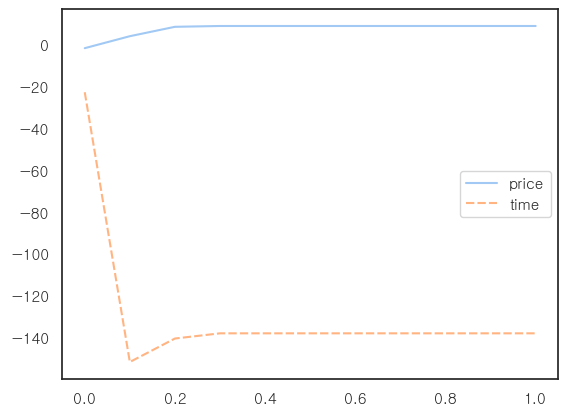

In [68]:
sns.lineplot(data=p)
plt.show()

*Q. w = 0.3 이후 입지 동일?*

위 그래프는 가중치에 따라 선정된 입지의 
**경제성과 접근성 변화**를 나타낸 것입니다. 

이 그래프에서 가중치 증가에 따른 시간거리의 감소폭을 살펴보면, 
가중치가 **0.1에서 0.2으로** 변할 때 
비용 증가에 따른 **시간거리의 감소분이 가장 크나**
**0.3 이후부터는 그 변화가 점차 약해짐**을 확인할 수 있습니다.

따라서 **가중치가 커질수록** 해당 입지에 들어설 경우, 
입지 후보지 간 공시 지가의 차이에서 오는 경제적 이익에 비해 
**접근성으로 얻는 이익이 더 커지게 되고** 
그 결과 가중치 0.3 이상부터는 선정된 입지가 동일해집니다.

#### <수요지 - 후보지 간 영향>

In [69]:
line_df1 = pd.DataFrame()

In [70]:
line_df1['lat'] = line_df['a_lat'].append(line_df['s_lat'])
line_df1['group'] = line_df1['lat'].index
line_df1['lng'] = line_df['a_lng'].append(line_df['s_lng'])
line_df1['weight'] = line_df['weight'].append(line_df['weight'])

In [140]:
# 선정지와 수요지의 edge plot
fig1 = px.line_mapbox(line_df1,lat='lat',lon='lng',
                        center = {"lat": 37.5, "lon": 126.9},zoom=9,
                      animation_frame='weight', line_group='group',
                      color=['green']*1210, color_discrete_map='identity'
                       )

In [141]:
# 수요지 plot
fig2 = px.scatter_mapbox(demand,lat='위도',lon='경도',
                        range_color=[0,3],
                        center = {"lat": 37.5, "lon": 126.9},zoom=9,
                        hover_name='이름', color_discrete_map='identity', color=['red']*55
                       )

In [142]:
fig.add_trace(fig2.data[0])
for i in range(55):
    fig.add_trace(fig1.data[i])
for i, frame in enumerate(fig.frames):
    fig.frames[i].data += (fig2.data[0],)
    for j in range(55):
        fig.frames[i].data += (fig1.frames[i].data[j],)

fig.layout['sliders'][0]['active'] = 1

In [143]:
fig = go.Figure(data=fig['frames'][1]['data'], frames=fig['frames'], layout=fig.layout)
fig

- 위 지도에서 **푸른 점**은 **선정된 입지**, **붉은 점**은 **수요지**, **초록색 선**은 **입지가 선택되는 데 영향을 많이 준 수요지와 해당 선정 입지를 이은 선** 입니다.
즉, 푸른 점(선정된 입지)은 **자신과 연결된 붉은 점(수요지)으로부터 가장 큰 영향을 받아 최종 입지로 선정**되었음을 나타냅니다.

- 가중치 w가 0일 때는 경제성(공시지가)만을 고려하기 때문에, 수요지의 영향과는 상관 없이 입지가 선정됩니다. 
따라서 w=0일 경우, 지가가 가장 낮은 **의정부시 가능동 581-1번지**로 입지가 선정되었고 모든 수요지들이 가능동과 연결되어 있습니다.

## 5. 결론

### a. 활용방안

![노고산](https://github.com/victolee0/dacon/blob/master/%ED%94%BC%ED%94%BC%ED%8B%B0_%EB%85%B8%EA%B3%A0%EC%82%B03.png?raw=true)

### b. 의의 및 한계

#### 의의
- 기존 K - median 알고리즘은 입지 선정 시 접근성만 고려하였지만, 본 분석은 보다 **현실적인 입지 선정 결과**를 얻기 위해 목적함수를 수정하여 경제성도 함께 고려하였습니다.
- 기존에는 공공 주택 공급이 비교적 자의적(국공유지 또는 신청)으로 진행된 것에 반하여 본 분석은 접근성과 경제성이라는 **사업의 맥락적, 공간적 측면에서 보다 실증적인 접근**을 통해 최적화된 입지 대안들을 제시하고 있습니다. 
- 이러한 접근은 실제 공간상의 최적 입지 뿐 아니라 행복주택이 갖는 목표상의 모순에 대한 중요한 시사점을 보여주고 있으며, 특히 **다양한 현실적 상황을 고려해야하는 정책 입안자와 의사결정자에게 유용하게 활용**될 수 있을 것으로 기대됩니다.

#### 한계
- 입지가 선정될 때 **조건이 비슷한 주변의 입지가 함께 선정되어 비슷한 지역으로 몰리는 결과**가 나왔습니다. 해결책으론 한 지역구에 한 후보지만 선정되도록 제약 조건을 추가하는 방법이 있는데, 끝내 한계점으로 남아있습니다.
- 또한, 행복주택을 건설하기 위한 실제적인 후보지를 제안하고 있지만, 현실에 직접 적용되기 위해서는 **추가적으로 고려되어야 할 사항들**이 있습니다. 가령 해당 토지의 소유 형태를 예로 들 수 있는데, 이는 비용 산정이나 사업 시행에 있어 중요한 변수가 될 수 있습니다. 이와 유사하게 실제 예산 및 비용 산정 역시 공시지가에서 그칠 것이 아니라 **보다 현실화된 방법을 적용할 필요**가 있어보입니다. 

![참고](https://github.com/victolee0/dacon/blob/master/%ED%94%BC%ED%94%BC%ED%8B%B0_%EC%B0%B8%EA%B3%A0.png?raw=true)

본 제출물은 Apache License v.2.0 라이센스를 따릅니다.